# <u>Everything Plus: E-Commerce Customer Segmentation Study<u/>
    
by Jonathan Chan

**NOTE:**
<br>
Presentation Link: https://drive.google.com/file/d/1hE-8tYLijMVaH8KJ79w_zui0VFrZBO8h/view?usp=sharing
<br>Dashboard Link: https://public.tableau.com/app/profile/jonathan.chan5881/viz/Finals-RFMSegmenationDashboard/Dashboard1?publish=yes

## <u>Table of contents<u/><a id='back'><a/>
* [1. Problem Statement](#ps)
    * [1.1. Preliminary Hypotheses](#hypotheses)
* [2. Data Preprocessing](#dp)
    * [2.1. Missing Value Treatment](#dp1)
    * [2.2. Investigating Extreme Values](#dp2)
    * [2.3. Outlier Treatment](#dp3)
        * [Conclusions on Data Preprocessing](#dpconclusion)
* [3. Exploratory Data Analysis (EDA)](#eda)
    * [3.1. Data Distribution by Invoice Date/Invoice Month](#eda1)
    * [3.2. Purchase Value by Unique Invoice](#eda2)
    * [3.3. Basket Size by Unique Invoice](#eda3)
    * [3.4. Time-based Revenue and Behavioural Metrics](#eda4)
    * [3.5. Purchase Frequency & Basket Size by Day Of Week](#eda5)
    * [3.6. Time Delta between Transactions & Total Purchase Frequency](#eda6)
    * [3.7. Relationship Between Purchase Frequency & Future Purchase Frequency (Chi-Test)](#eda7)
    * [3.8. LTV x [Purchase Frequency | Purchase Value | Basket Size]](#eda8)
    * [3.9. Price Sensitivity – Feature Engineering ](#eda9)
        * [Conclusions on EDA](#edaconclusion)  
* [4. Recency Frequency Monetary (RFM) Segmentation](#rfm)
    * [4.1. RFM Score Calculations](#rfm1)
    * [4.2. Customer Segments by RFM Scores](#rfm2)
* [5. Unsupervised Learning - Segmentation by Clustering](#ml)
    * [5.1. Avoiding Multicollinearity](#ml1)
    * [5.2. Hierarchical Clustering for Estimation of n–clusters](#ml2)
    * [5.3. K-Means Clustering](#ml3)
    * [5.4. Interpreting K-Means Results](#ml4)   
* [6. Findings and Overall Conclusion](#findings) 
    * [6.1. Hypothesis Exploration towards Customer Segmentation](#findings1)
    * [6.2. RFM Segmentation](#findings2)
    * [6.3. K-Means Clustering Segmentation](#findings3)

# 1. Problem Statement <a id='ps' ><a/>
Our client **"Everything Plus: Plus A Little Bit More!"** is an e-commerce platform that delves in household goods. Their near-term goal is to have the ability to personalize their offerings to different segments of their customer base. Unfortunately, the client does not have personal and demographic data for its customers, thus we will be using historical transactional data from their website. The end goal would ideally result in an increase in conversion rates of 5-7%, which should lead to improved customer experience and therefore, higher repeat purchases and brand salience. The end result of our segmental analysis will be used by the client's product manager for creation of promotional offerings.
    
- **Problem Statement:**
<br>The client has specified a need for identifying distinct customer profiles out of their web channel &ndash; <u>Customer Segmentation Problem</u>.  
<br><br>
- **Primary Objective:**
<br>To run personalized offers for distinct customer profiles.
<br><br>
- **Success Indicator(s):**
<br>Increase in conversion rates &ndash; Running personalized offers will hopefully lead to greater user experience, of which will generate better brand salience and retention, while also aiding in word of mouth traffic. <u>Target Conversion Rates: 5 &ndash; 7%</u>
<br><br>
- **Time Period:**
<br>Approximately a year.
<br><br>
- **Gap Analysis:**
<br>Qualitative research has been done, but none with data manipulation. The client does not possess intrinsic personal data on its customers; they only have transactional data at their disposal.
<br><br> 
- **Key End User:** 
<br>Our analysis will be used by the client's <u>product manager</u>.
<br><br>
- **Key Decisions:** 
<br> Unique personalized offerings will be made for each distinct customer profile we can identify.
<br>

## 1.1. Preliminary Hypotheses <a id='hypotheses' ><a/>

The following are preliminary hypotheses generated based on the raw data observed and with customer segmentation being the key underlying focus. These will be tested accordingly in the data exploration sections.
    
1. **Seasonality factors** &ndash; Seasonalities affects sales, whereby sales are highest towards the end of the year. 
<br><br>
2. **Day of the week transactions** &ndash; Customers are more likely to make purchases over the weekend than weekdays. 
<br><br>
3. **Time elapsed between transactions** &ndash; Customers with shorter time deltas between transactions are more likely to exhibit higher repeat purchase behavior, indicating higher engagement/loyalty. (and vice versa)
<br><br>
4. **Purchase frequency (first order month) and average purchase frequency (proceeding months) are likely dependent on each other** &ndash; Customers are likely to exhibit similar purchasing frequency in their lifetime based on their behaviour in the first order month.
<br><br>
5. **Purchase Frequency has a higher impact on LTV compared to Average Purchase Value and Average Basket Size** &ndash; Customers who transact frequently are likely to generate higher Lifetime Value and subsequently, better loyalty and retention rates. This is irrespective of invoice value of that particular purchase or their quantities purchased.
<br><br>
6. **Customer segments differ in terms of their average basket size (average quantity) and average frequency of purchase** &ndash; For example, one segment may consist of bulk buyers who purchase in larger quantities, while another segment may consist of more occasional shoppers with smaller purchase quantities.     

In [1]:
# Libraries

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import re

from scipy import stats 
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os

In [2]:
## Defining Functions for k-means feature distribution analysis

# barplots
def barplot_feature_cluster(data, feature, hue='customer_segment',
                            xlim=None, ylim=None, figsize=(8, 5), title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.countplot(x=feature, hue=hue, data=data, palette='colorblind', ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10})
    plt.tight_layout()
    
# histplots
def histplot_cluster(data, feature, hue='customer_segment', bins=10, alpha=0.7, 
                     xlim=None, ylim=None, figsize=(8, 5), title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(data=data, x=feature, hue=hue, multiple='dodge', edgecolor='black', linewidth=0.5,
                 kde=False, alpha=alpha, bins=bins, palette='colorblind', ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    plt.tight_layout()


# strip plots
def strip_plot_cluster(data, feature, x='customer_segment', alpha=0.5, jitter=0.5, linewidth=0.5, 
                       xlim=None, ylim=None, figsize=(8, 5), title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data=data, x=x, y=feature, jitter=jitter, linewidth=linewidth,
                  alpha=alpha, palette='colorblind', edgecolor='black', ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    plt.tight_layout()

In [3]:
# Reading csv data

try:
    df = pd.read_csv('ecommerce_dataset_us.csv', sep='\t')
except:
    df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')

In [4]:
# Overview of data

display(df.info(memory_usage='deep'))
display(df.describe())
display(df.head())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 157.9 MB


None

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


(541909, 7)

In [5]:
# Checking for complete duplicates

display(df.duplicated().sum())
(df.duplicated().sum()) / len(df) 

5268

0.009721189350979592

**Preliminary Data Issues:**
1. Column renaming to lower-case and snake-case.
2. Decription column to be converted to lower-case for better readability.
3. Invoice_date column will be converted from String type to the DateTime type.
4. Missing values are found in columns 'description' and 'customer_id'. 
5. Extreme min and max values were found columns 'quantity' and 'unit_price'.
6. 5268 records (0.9% share of data) of complete duplicates were found.

[Back to Contents](#back)

# 2. Data Preprocessing <a id='dp'><a/>

In [6]:
# Renaming Columns to the snake_case
# Converting description column to lower case
# Converting invoice_date column to a Datetime object

df.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df['description'] = df['description'].str.lower()
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format="%m/%d/%Y %H:%M", dayfirst=True)

In [7]:
# Checking nature of complete duplicates, if they are indeed dulicated

display(df[df.duplicated()].head())
df.query("invoice_no == '536409' and stock_code == '22900'")

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
517,536409,21866,union jack flag luggage tag,1,2018-11-29 11:45:00,1.25,17908.0
527,536409,22866,hand warmer scotty dog design,1,2018-11-29 11:45:00,2.10,17908.0
537,536409,22900,set 2 tea towels i love london,1,2018-11-29 11:45:00,2.95,17908.0
539,536409,22111,scottie dog hot water bottle,1,2018-11-29 11:45:00,4.95,17908.0
555,536412,22327,round snack boxes set of 4 skulls,1,2018-11-29 11:49:00,2.95,17920.0


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
521,536409,22900,set 2 tea towels i love london,1,2018-11-29 11:45:00,2.95,17908.0
537,536409,22900,set 2 tea towels i love london,1,2018-11-29 11:45:00,2.95,17908.0


In [8]:
# Removing complete duplicates

df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

[Back to Contents](#back)

<br>

## 2.1. Missing Value Treatment <a id='dp1' ><a/>

### <u>Description column<u/>

In [9]:
# Overview of Missing values in Description column

display(df['description'].isna().sum())
df[df['description'].isna()].sort_values('quantity', ascending=False).head(12)

1454

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
73890,542504,37413,NaN,5568,2019-01-26 12:03:00,0.0,NaN
73891,542505,79063D,NaN,2560,2019-01-26 12:04:00,0.0,NaN
82007,543258,84611B,NaN,1287,2019-02-02 16:06:00,0.0,NaN
135285,547966,DOT,NaN,1000,2019-03-26 15:49:00,0.0,NaN
51721,540699,POST,NaN,1000,2019-01-09 09:32:00,0.0,NaN
79890,543051,79062D,NaN,960,2019-02-01 10:15:00,0.0,NaN
450016,575505,POST,NaN,800,2019-11-08 10:29:00,0.0,NaN
204282,554857,POST,NaN,800,2019-05-25 10:08:00,0.0,NaN
324015,565556,POST,NaN,750,2019-09-03 12:14:00,0.0,NaN
333680,566316,23306,NaN,682,2019-09-10 10:07:00,0.0,NaN


**Potential Assumption:** Stock Codes of alphabetic values are miscellaneous items.

In [10]:
# Checking our assumption

df.query("stock_code.str.isalpha()")['description'].value_counts()

postage                       1252
dotcom postage                 709
manual                         567
discount                        77
samples                         62
amazon fee                      34
cruk commission                 16
girls party bag                 13
boys party bag                  11
pads to match all cushions       4
adjust bad debt                  3
Name: description, dtype: int64

In [11]:
# Obtaining descriptions of alpha-only stock codes as they represent misc items, while keeping 3 relevant descriptions 
values_to_drop = df.query("stock_code.str.isalpha()")['description'].value_counts().index
values_to_drop = (values_to_drop
                  .drop(['girls party bag', 'boys party bag', 'pads to match all cushions']))

# Filtering data to exclude the above descriptions
df = df[~df['description'].isin(values_to_drop)]

# Dropping the remaining alpha-only stock codes that represent misc items (missing descriptions) 
df = df.drop(df.query("stock_code == 'POST' or stock_code == 'DOT'").index).reset_index(drop=True)

In [12]:
# Filling remaining missing values in Description with mode of grouped stock code descriptions
df['description'] = df.groupby('stock_code')['description'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))

# Filtering out entries with 'unknown' descriptions
df = df.query("description != 'unknown'")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533803 entries, 0 to 533914
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    533803 non-null  object        
 1   stock_code    533803 non-null  object        
 2   description   533803 non-null  object        
 3   quantity      533803 non-null  int64         
 4   invoice_date  533803 non-null  datetime64[ns]
 5   unit_price    533803 non-null  float64       
 6   customer_id   399839 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 32.6+ MB


[Back to Contents](#back)

<br>

### <u>Customer_id column<u/>

In [13]:
print("Proportion of missing Customer_id values: ", round(len(df.query("customer_id.isna()")) / len(df), 2))
display(df.query("customer_id.isna()"))

Proportion of missing Customer_id values:  0.25


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
602,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.00,NaN
1403,536544,21773,decorative rose bathroom bottle,1,2018-11-29 14:32:00,2.51,NaN
1404,536544,21774,decorative cats bathroom bottle,2,2018-11-29 14:32:00,2.51,NaN
1405,536544,21786,polkadot rain hat,4,2018-11-29 14:32:00,0.85,NaN
1406,536544,21787,rain poncho retrospot,2,2018-11-29 14:32:00,1.66,NaN
...,...,...,...,...,...,...,...
533553,581498,85049e,scandinavian reds ribbons,4,2019-12-07 10:26:00,3.29,NaN
533554,581498,85099B,jumbo bag red retrospot,5,2019-12-07 10:26:00,4.13,NaN
533555,581498,85099C,jumbo bag baroque black white,4,2019-12-07 10:26:00,4.13,NaN
533556,581498,85150,ladies & gentlemen metal sign,1,2019-12-07 10:26:00,4.96,NaN


In [14]:
# Checking if invoice numbers for missing customer_ids are present in our non-null data

unique_invoice_na = df.query("customer_id.isna()")['invoice_no'].unique()
df_non_null = df.query("customer_id.notna()")
df_non_null.query("invoice_no in @unique_invoice_na")

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id


**Observations:** There doesn't seem to be any relation between the missing values of customer id and invoice numbers. However we will not drop them as they represent a substantially big proportion of available records, roughly 25% of data share. 
<br>What we can do, is to work with two separate DataFrames concurrently at separate junctures of our study. Because of the sheer size our DataFrame, we can assume the distribution visualizations of both datasets to be representative of each other based on the **Central Limit Theorem** (CLT). The CLT states that as the sample size increases, the sample mean converges on the population mean.
<br><br>
***Separation of data will be performed after examining potential outliers.***


[Back to Contents](#back)

<br>

## 2.2. Investigating Extreme Values <a id='dp2'><a/>

### <u>Unit Price Column<u/>

In [15]:
# Investigating unit price of 0.0

display(df[df['unit_price'] <= 0].head())
len(df[df['unit_price'] <= 0])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
602,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.0,NaN
1930,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
1931,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
1980,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN
2355,536589,21777,recipe box with metal heart,-10,2018-11-29 16:50:00,0.0,NaN


2384

In [16]:
# Replacing our 2384 entries with 0.0 unit_price with the mode price grouped by description

df['unit_price'] = df.groupby('description')['unit_price'].transform(lambda x: x.replace(0.0, x.mode()[0]))
display(df[df['unit_price'] <= 0].head())
len(df[df['unit_price'] <= 0])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
1930,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
1931,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
1980,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN
6277,536941,22734,amazon,20,2018-12-01 12:08:00,0.0,NaN
6278,536942,22139,amazon,15,2018-12-01 12:08:00,0.0,NaN


756

In [17]:
# Forward filling entries of which did not have a mode reading due to having exactly 1 unit_price observation

df['unit_price'] = df.groupby('description')['unit_price'].transform(lambda x: x.replace(0.0, method='ffill'))

In [18]:
# Visualizing remaining entries that did not forward fill

display(df.query("unit_price == 0"))
print("\033[1mBiggest proportion share for remaining entries of [unit_price == 0] seem to be Misc items.")
df.query("unit_price == 0").description.value_counts().head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
1930,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
1931,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
1980,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN
6277,536941,22734,amazon,20,2018-12-01 12:08:00,0.0,NaN
6278,536942,22139,amazon,15,2018-12-01 12:08:00,0.0,NaN
...,...,...,...,...,...,...,...
527396,581211,22142,check,14,2019-12-05 18:36:00,0.0,NaN
527397,581212,22578,lost,-1050,2019-12-05 18:38:00,0.0,NaN
527398,581213,22576,check,-30,2019-12-05 18:38:00,0.0,NaN
528968,581226,23090,missing,-338,2019-12-06 09:56:00,0.0,NaN


Biggest proportion share for remaining entries of [unit_price == 0] seem to be Misc items.


check                     162
damaged                    58
damages                    47
?                          47
found                      34
sold as set on dotcom      20
amazon                     18
adjustment                 18
thrown away                10
unsaleable, destroyed.      9
Name: description, dtype: int64

**Observation:** Majority of entries that were unable to be filled with any relationship-based transformation were found to represent miscallaneous items such as (1) Affiliate transactions via Amazon and other websites, (2) destroyed and missing goods, (3) credit adjustments and the lot. Not all entries were found to be of this nature, as they did represent actual goods being sold by the store. Unfortunately, we did not have any way to determine their prices and seeing as percentage share of these entries are only 0.1%, we will proceed to drop them. 

In [19]:
# Dropping remaining entries of unit_price == 0

df = df.drop(df[df['unit_price'] == 0].index).reset_index(drop=True)
df.shape

(533134, 7)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533134 entries, 0 to 533133
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    533134 non-null  object        
 1   stock_code    533134 non-null  object        
 2   description   533134 non-null  object        
 3   quantity      533134 non-null  int64         
 4   invoice_date  533134 non-null  datetime64[ns]
 5   unit_price    533134 non-null  float64       
 6   customer_id   399839 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.5+ MB


[Back to Contents](#back)

<br>

### <u>Quantity Column<u/>

In [21]:
# Investigating extreme negative values in quantity

display(df.query("quantity <= 0"))
len(df.query("quantity <= 0")) / len(df)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
152,C536383,35004C,set of 3 coloured flying ducks,-1,2018-11-29 09:49:00,4.65,15311.0
233,C536391,22556,plasters in tin circus parade,-12,2018-11-29 10:24:00,1.65,17548.0
234,C536391,21984,pack of 12 pink paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0
235,C536391,21983,pack of 12 blue paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0
236,C536391,21980,pack of 12 red retrospot tissues,-24,2018-11-29 10:24:00,0.29,17548.0
...,...,...,...,...,...,...,...
531688,C581490,22178,victorian glass hanging t-light,-12,2019-12-07 09:57:00,1.95,14397.0
531689,C581490,23144,zinc t-light holder stars small,-11,2019-12-07 09:57:00,0.83,14397.0
532943,C581568,21258,victorian sewing box large,-5,2019-12-07 11:57:00,10.95,15311.0
532944,C581569,84978,hanging heart jar t-light holder,-1,2019-12-07 11:58:00,1.25,17315.0


0.017715996353637173

In [22]:
# Ensuring all invoice numbers that start with the letter C are return items

filtered_entries = df[df['invoice_no'].str.contains('^C')]
filtered_entries.query("quantity > 0")

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id


In [23]:
# Removing returned items/ quantities < 0

df = df.drop(df[df['quantity'] < 0].index).reset_index(drop=True)

**Observations:** The most logical explanation for our negative quantity values (1.7%) are that these entries represent returned items. We will be removing these entries as we are more interested in the segmentation on purchasing behaviours of customers and not so much the segmentation of products here.

## Conclusions on Data Preprocessing <a id='dpconclusion'><a/>

* Complete duplicates were found, amounting to roughly 1% of our data. These entries were dropped.
* We investigated stock codes of only alpha characters - apart from 3 instances, the majority represented misc items like post, bad debt and affiliate transactions. These were dropped.
* Missing values in the Descriptions column were filled with the mode descriptions of grouped stock codes. A number of these entries (0.02%) did not have a prior valid observation to relate to, and were dropped.
* Missing values in the Customer_id column were attempted to be filled with the mode id's of grouped invoice numbers. Unfortunately, this did not execute as there was no dependency-based relation whatsoever. We decided not to remove them as they represent a large share of data proportion. Instead, we will separate our data into complete raw data and non-null data after outlier treatment; these will be analyzed simultaneously if and when the situation deems it appropriate.
* 2384 Unit_price entries were found to be 0. We replaced these with the mode price of grouped stock codes. A portion still remained after the fact, and were found to be largely comprised of miscellaneous items like affiliate-link transactions (Amazon), credit adjustments and missing goods. We dropped these entries as they are irrelevant to observing the client's customer behaviour.
* About 9445 Quantity entries (1.7%) were found to be negative values. We can only assume they are returned goods and therefore were removed from our dataset as we are more interested in customer segmentation based on purchasing behaviour and not so much product segmentation.

[Back to Contents](#back)

<br>

# 3. Exploratory Data Analysis (EDA) <a id='eda' ><a/>

## 3.1. Data Distribution by Invoice Date/Invoice Month<a id='eda1'><a/>

In [24]:
# Features engineering - INVOICE_MONTH

df['invoice_month'] = df['invoice_date'].astype('datetime64[M]')

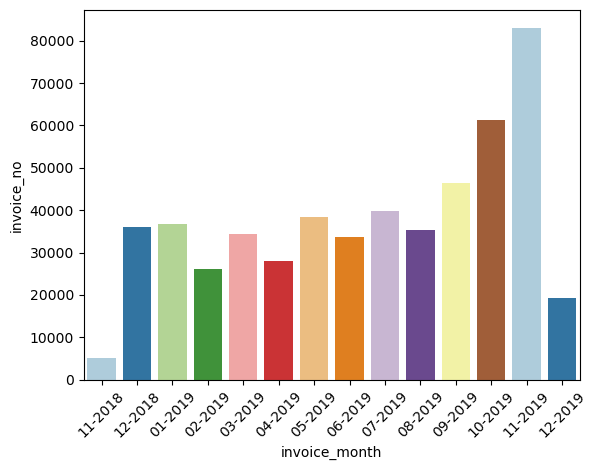

Dataset Start Date: 2018-11-29 08:26:00
Dataset End Date: 2019-12-07 12:50:00


In [25]:
# Visualizing POTENTIAL OUTLIERS for data volume by month

volume_by_month = df.groupby('invoice_month', as_index=False)['invoice_no'].count()
volume_by_month['invoice_month'] = volume_by_month['invoice_month'].dt.strftime('%m-%Y')
sns.barplot(data=volume_by_month, x='invoice_month', y='invoice_no', palette='Paired')

plt.xticks(rotation=45)
plt.show()

# Checking our minimum and maximum datetime values
print("Dataset Start Date:", df['invoice_date'].min())
print("Dataset End Date:", df['invoice_date'].max())

In [26]:
# Filtering out data for NOV 2018 and DEC 2019

df = df.query("invoice_month != '2018-11-01' and invoice_month != '2019-12-01'").reset_index(drop=True)
df.shape

(499437, 8)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499437 entries, 0 to 499436
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     499437 non-null  object        
 1   stock_code     499437 non-null  object        
 2   description    499437 non-null  object        
 3   quantity       499437 non-null  int64         
 4   invoice_date   499437 non-null  datetime64[ns]
 5   unit_price     499437 non-null  float64       
 6   customer_id    374558 non-null  float64       
 7   invoice_month  499437 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 30.5+ MB


**Observations:** There is a clear disparity in data volume for the first and last month of our dataset, due to our timeline starting late into November, 2018 and ending in early December, 2019. We dropped these months as they do not provide us with a full month's worth of data. This will also give us a strict **12-month period to work with**.

[Back to Contents](#back)

<br>

## 3.2. Purchase Value by Unique Invoice<a id='eda2'><a/>

In [28]:
# Engineering a revenue feature

df['revenue'] = df['quantity'] * df['unit_price']

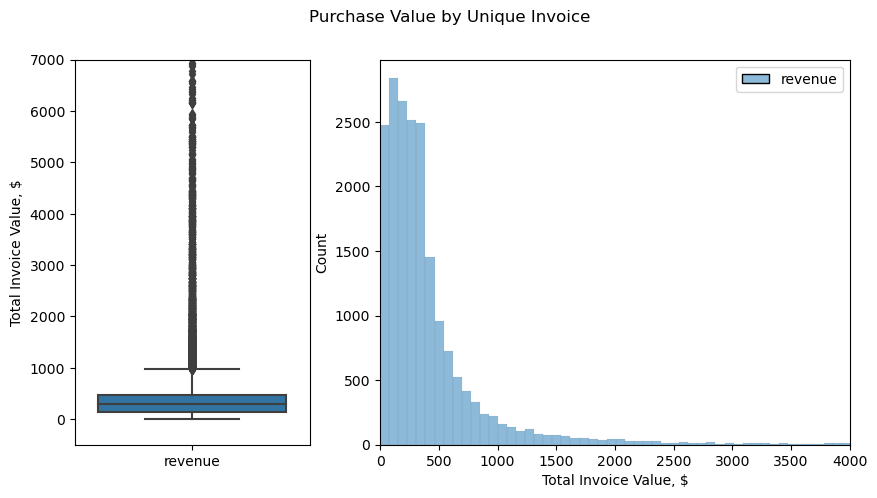

[1472.36 1705.5  2050.08 2739.92 4287.73 6207.67]
Median Invoice Purchase Value: 299.805


In [29]:
# Visualizing the distribution  of purchase value by unique invoice number

revenue_by_invoice = df.groupby('invoice_no', as_index=False)['revenue'].sum()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Purchase Value by Unique Invoice")
fig.set_figheight(5)
fig.set_figwidth(10)

width_ratios = [1, 2]
gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.boxplot(data=revenue_by_invoice, ax=ax1)
ax1.set_ylabel('Total Invoice Value, $')
ax1.set_ylim(-500, 7000)

sns.histplot(data=revenue_by_invoice, bins=1000, ax=ax2)
ax2.set_xlabel('Total Invoice Value, $')
ax2.set_ylabel('Count')
ax2.set_xlim(0, 4000)
plt.show()

print(np.percentile(revenue_by_invoice['revenue'], [95, 96, 97, 98, 99, 99.5], interpolation='nearest'))
print("Median Invoice Purchase Value:", revenue_by_invoice.revenue.median())

In [30]:
# Filtering out customer ID's possessing invoices above our 99.5th revenue percentile of $6207.67

revenue_by_invoice_outliers = revenue_by_invoice.query("revenue >= 6207.67")
outlier_customers = df.query("invoice_no in @revenue_by_invoice_outliers.invoice_no").drop_duplicates(subset='customer_id')
df = df.query("customer_id not in @outlier_customers.customer_id").reset_index(drop=True)
df.shape

(361032, 9)

**Observations:** 
Distribution of total purchase value by unique invoices are clustered around the \\$300 mark, with a right skew that represents a large variation of customers who potentially purchase on a bulk basis.
<br>We definitely have some potential outliers here then, but the clustering of potential bulk buyers occuring above the upper threshold of our boxplot can't be recognized as anomalies, as they are large in size and continuous in nature. These are a segment of unique customers it and of itself. Nevertheless, we can observe a slight dispersion in the continuous clusters of potential anomalies around the \\$6000 mark which ties in with our 99.5th percentile values. We used $6207 as our filtering threshold for outliers.

[Back to Contents](#back)

<br>

## 3.3. Basket Size by Unique Invoice<a id='eda3'><a/>

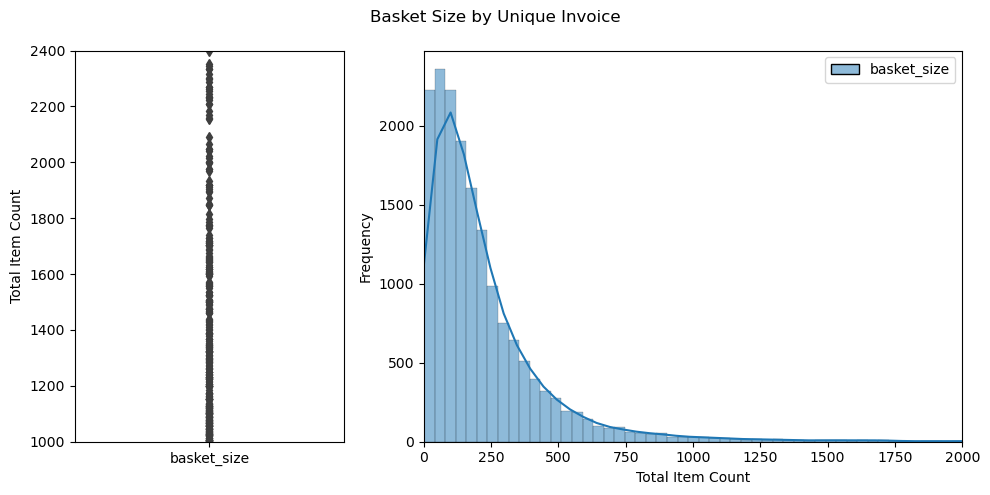

[ 480  670  748  864 1047 1500 2048]
Mode Invoice Basket Size: 24
Median Invoice Basket Size: 152.0
Upper Limit: 594.0


In [31]:
# # Visualizing the distribution  of basket size by unique invoice number

basket_size_invoice = df.groupby('invoice_no', as_index=False)['quantity'].sum()
basket_size_invoice = basket_size_invoice.rename(columns={'quantity': 'basket_size'})

Q1 = basket_size_invoice['basket_size'].quantile(0.25)
Q3 = basket_size_invoice['basket_size'].quantile(0.75)
IQR = Q3 - Q1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Basket Size by Unique Invoice")
fig.set_figheight(5)
fig.set_figwidth(10)

width_ratios = [1, 2]
gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.boxplot(data=basket_size_invoice, ax=ax1)
ax1.set_ylabel('Total Item Count')
ax1.set_ylim(1000, 2400)

sns.histplot(data=basket_size_invoice, kde=True, bins=250, ax=ax2)
ax2.set_xlabel('Total Item Count')
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 2000)

plt.tight_layout()
plt.show()


print(np.percentile(basket_size_invoice['basket_size'], [90, 95, 96, 97, 98, 99, 99.5], interpolation='nearest'))
print("Mode Invoice Basket Size:", basket_size_invoice.basket_size.mode()[0])
print("Median Invoice Basket Size:", basket_size_invoice.basket_size.median())
print("Upper Limit:", Q3 + 1.5 * IQR)


In [32]:
# Removing customer id's posessing above 2048 basket size 

basket_outliers = basket_size_invoice.query("basket_size >= 2048")
basket_outlier_customers = df.query("invoice_no in @basket_outliers.invoice_no").drop_duplicates(
    subset='customer_id')
df = df.query("customer_id not in @basket_outlier_customers.customer_id").reset_index(drop=True)
df.shape

(345141, 9)

**Observations:** The median average basket size of the typical invoice is roughly 152 item quantities. We can observe an extremely right skewed distribution, indicating yet again there are a subset of bulk purchases.
Despite calculating our percentiles, our boxplot clearly shows a continuous trail of invoices that transact large amounts of items in a single order. This starts to disperse at roughly the 2100 item mark, after which we notice a reasonable gap to the next set of observations. We considered the 99.5th percentile (2048) as our cut-off point to process anomalies.

**N.B.** *We can now safely subset our data of non-null Customer ID data and work with two simultaenously on both DataFrames.*

In [33]:
# Creating a separate DataFrame with dropped NULL customer id entries

df1 = df.query("customer_id.notna()").reset_index(drop=True)


# Reducing the size of our data

df1['quantity'] = df1['quantity'].astype('int16')
df1['unit_price'] = df1['unit_price'].astype('float16')
df1['customer_id'] = df1['customer_id'].astype('int32')

df['quantity'] = df['quantity'].astype('int16')
df['unit_price'] = df['unit_price'].astype('float16')
df['customer_id'] = df['customer_id'].astype('float32')

[Back to Contents](#back)

<br>

## 3.4. Time-based Revenue and Behavioural Metrics <a id='eda4'><a/>

<br> 
    
**NOTE:** Testing the hypothesis that "Seasonalities affect sales, whereby sales are highest towards the end of the year".


### <u>Total Revenue & Total Order Volume by Month</u>

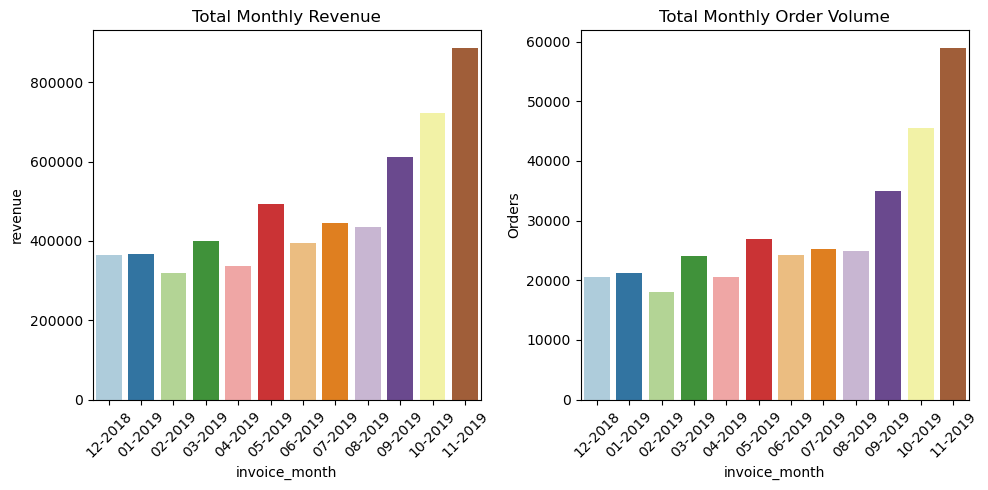

In [34]:
# Visualizing TOTAL MONTHLY REVENUE and TOTAL MONTHLY ORDER VOLUME

revenue_by_month = df.groupby('invoice_month', as_index=False)['revenue'].sum()
revenue_by_month['invoice_month'] = revenue_by_month['invoice_month'].dt.strftime('%m-%Y')

orders_by_month = df.groupby('invoice_month', as_index=False)['invoice_no'].count()
orders_by_month['invoice_month'] = orders_by_month['invoice_month'].dt.strftime('%m-%Y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(data=revenue_by_month, x='invoice_month', y='revenue', ax=ax1, palette='Paired')
sns.barplot(data=orders_by_month, x='invoice_month', y='invoice_no', ax=ax2, palette = 'Paired')

ax1.set_title('Total Monthly Revenue')
ax1.tick_params(axis='x', rotation=45)
ax2.set_title('Total Monthly Order Volume')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Orders')
plt.tight_layout()

fig.savefig("plots/monthly_revenue_volume", dpi=200)

plt.show()

**Observations:** We can observe total revenue and purchase volume increase dramatically towards the latter months of the year from September to November. December saw lower metrics all around, but we can attribute this to a lack of demand for hosuehold goods and an increased in demand for items of the 'gifting' nature, as we would assume for the Christmas period. September marks the end of Summer and the start of the schooling semester. October sees the Halloween festival come into play and November ushers in Thanksgiving and Black Friday sales. **There is a very notable seasonal effect at play here and our hypothesis is accepted in terms of purchase volume and revenue towards the latter months of the year.**

### <u>Average Purchase Value by Month</u>

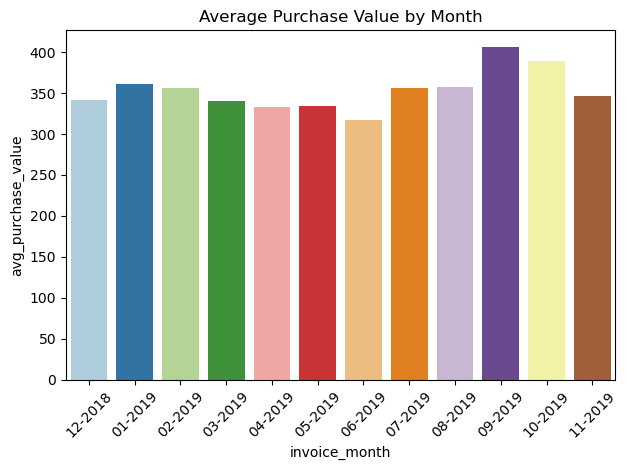

In [35]:
# Calculating AVERAGE PURCHASE VALUE 

avg_purchase_size = df.groupby('invoice_month', as_index=False).agg({'revenue': 'sum', 'invoice_no': 'nunique'})
avg_purchase_size.rename(columns={'revenue': 'total_revenue', 'invoice_no': 'total_unique_invoices'}, inplace=True)
avg_purchase_size['avg_purchase_value'] = avg_purchase_size['total_revenue'] / avg_purchase_size['total_unique_invoices']
avg_purchase_size['invoice_month'] = avg_purchase_size['invoice_month'].dt.strftime('%m-%Y')

sns.barplot(data=avg_purchase_size, x='invoice_month', y='avg_purchase_value', palette='Paired')
plt.xticks(rotation=45)
plt.title('Average Purchase Value by Month')
plt.tight_layout()

plt.savefig("plots/monthly_purchase_value", dpi=200)

plt.show()

**Observations:** In terms of the average purchase value for a typical invoice, there aren't any significant differences on display here. Most high value transactions happen in September and October, possibly explained by the end of the Summer holidays and preparation for the end year festivities that occur from November onwards. **Again, though not very apparent differences, there are some slight seasonal effects being observed here.**

### <u>Basket Size by Month</u>

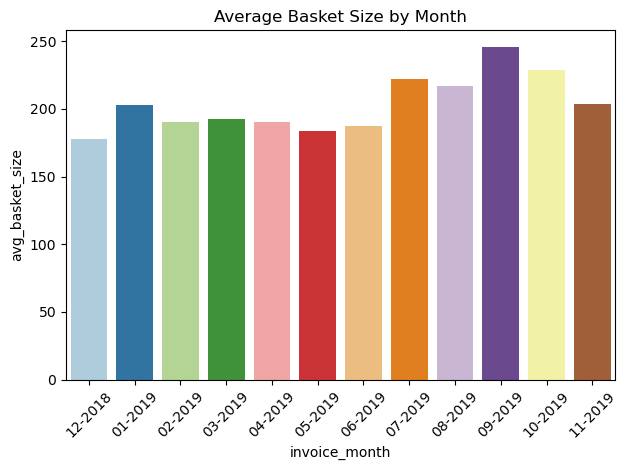

In [36]:
# Calculating AVERAGE BASKET SIZE by month

avg_basket_size = df.groupby('invoice_month', as_index=False).agg({'quantity': 'sum', 'invoice_no': 'nunique'})
avg_basket_size.rename(columns={'quantity': 'total_quantity', 'invoice_no': 'total_unique_invoices'}, inplace=True)
avg_basket_size['avg_basket_size'] = avg_basket_size['total_quantity'] / avg_basket_size['total_unique_invoices']
avg_basket_size['invoice_month'] = avg_basket_size['invoice_month'].dt.strftime('%m-%Y')

sns.barplot(data=avg_basket_size, x='invoice_month', y='avg_basket_size', palette='Paired')
plt.xticks(rotation=45)
plt.title('Average Basket Size by Month')
plt.tight_layout()

plt.savefig("plots/monthly_basket_size", dpi=200)

plt.show()

**Observations:** Regarding Average Basket Size, December has declined again and is more in line with our total revenue and order volume plots. However, something to note about the nature of our E-commerce business. December being the month for Christmas, typically sees the purchase of gifts; we expect some form of transaction volume decrease for household goods. January sees big increase in basket size before continuously dipping towards the middle of the month in June. We can attribute the high basket size values to be linked to post-Christmas clearances and the need to restock on household goods. As for the latter months on record, we yet agains see increases in average basket size values during the start of summer and end of summer months, coupled with relatively higher values for November, which has Thanksgiving and Black Friday sales to thank for. **We can observe some apparent seasonal trends when plotting average basket size by months.**

> **Intermediate Conclusion:** Our hypothesis is accepted. The latter months of the year, barring the month of December, have innately better revenue and purchase volume.

> **N.B.** As we have determined that there are seasonal effects towards customer purchasing behaviour, we shall engineer a feature of seasonal shoppers to our dataframe based on the nature of our business in question. Demand of household goods will spike the most during months of huge nationwide festivities, which are September to December. This holds true based on our graph on Total Purchase Volume which are. However, December saw low amounts of purchase volume, but we are including it anyways as Christmas is without a doubt one of the bigger holidays in North America. The following is the breakdown of each month: 
> - October &ndash; Halloween, transition to Fall and preparation for the Winter holidays
> - November &ndash; Thanksgiving (Black Friday), Single's Day, Veteran's Day
> - December &ndash; Christmas 

In [37]:
## Feature engineering - Seasonal shoppers

# Getting customer_id's for months of October to December
seasonal_months = ['2018-12-01', '2019-10-01', '2019-11-01']
seasonal_shoppers = df1[df1['invoice_month'].isin(seasonal_months)]['customer_id'].unique()

# Assigning them identifiers for seasonal shoppers
df1['seasonal_shopper'] = df1['customer_id'].apply(lambda x: 1 if x in seasonal_shoppers else 0)

[Back to Contents](#back)

<br>

## 3.5. Purchase Frequency & Basket Size by Day Of Week <a id='eda5'><a/>
   
<br> 
    
**NOTE:** Testing the hypothesis that "Customers are more likely to make purchases over the weekend than weekdays". 

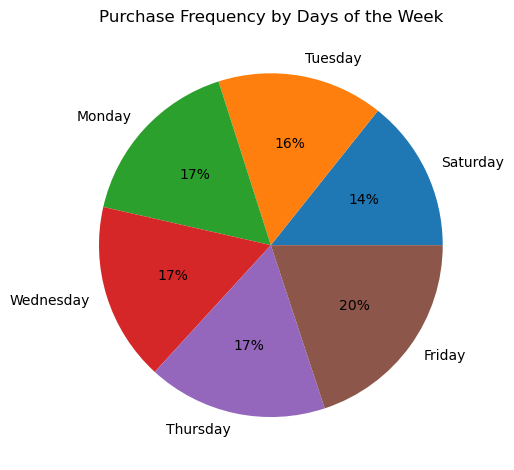

In [38]:
# Visualizing purchase frequency by day of week

df['invoice_day'] = df['invoice_date'].dt.strftime('%A')
invoices_day = df.groupby('invoice_day', as_index=False).agg({'invoice_no': 'count'}).sort_values('invoice_no')
plt.pie(x = invoices_day['invoice_no'], labels=invoices_day['invoice_day'], autopct='%.0f%%')
plt.title("Purchase Frequency by Days of the Week")
plt.tight_layout()

plt.savefig("plots/purchase_freq_week", dpi=200)

plt.show()

**Observations:** The most apparent observations here is that there are no records for Sunday. This could probably be explained by the e-commerce store going on break, or the store choosing not to take transactions on Sundays due to courier services going on break. Either ways, Saturday appears to be our lowest performing day in terms of purchase frequency. On the flipside, Friday  is the best performing day of the week, thus has the highest traffic of online shoppers. We then can infer that Friday's are the best days to run promotions.

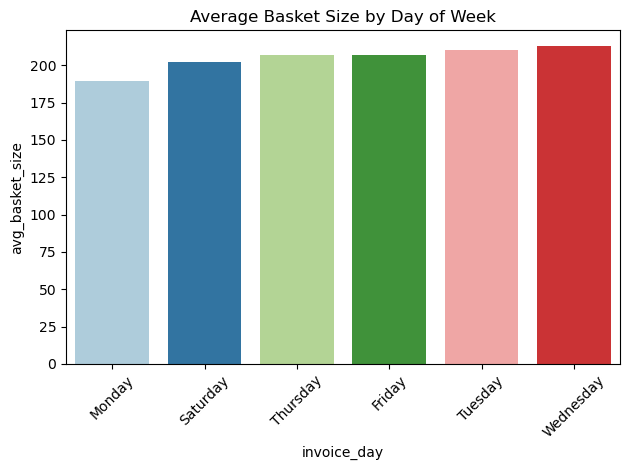

In [39]:
# avg basketsize by DoW

avg_basket_size_day = df.groupby('invoice_day', as_index=False).agg({'quantity': 'sum', 'invoice_no': 'nunique'})
avg_basket_size_day.rename(columns={'quantity': 'total_quantity', 'invoice_no': 'total_unique_invoices'}, inplace=True)
avg_basket_size_day['avg_basket_size'] = avg_basket_size_day['total_quantity'] / avg_basket_size_day['total_unique_invoices']
avg_basket_size_day = avg_basket_size_day.sort_values("avg_basket_size")

sns.barplot(data=avg_basket_size_day, x='invoice_day', y='avg_basket_size', palette='Paired')
plt.xticks(rotation=45)
plt.title('Average Basket Size by Day of Week')
plt.tight_layout()

plt.savefig("plots/basket_size_week", dpi=200)

plt.show()

**Observations:** The differences between basket size averages across all days of the week are marginal at best.

> **Intermediate Conclusion:** Our hypothesis of "Customers are more likely to make purchases over the weekend than weekdays" is refuted. 
> - Weekdays are better performing in terms of Average Purchase Frequency, in particular Friday, hence should be given higher focus as there is an increase in traffic.
> - Regarding Average Basket Size, the differences between all days of the week are marginal at best; also, we do not have a full weekend to work with. Segmenting by purchase metrics of day-of-weeks would not be a good idea as there isn't a large enough difference in trends.

[Back to Contents](#back)

<br>

## 3.6. Time Delta between Transactions & Total Purchase Frequency <a id='eda6'><a/>
    
<br>
    
**NOTE:** Testing the hypothesis that "Customers with shorter time deltas between transactions are more likely to exhibit higher repeat purchase behavior, indicating higher engagement/loyalty. (and vice versa)"

In [40]:
# Extracting average time delta between transactions for each customer_id

df1['invoice_date'] = df1['invoice_date'].astype('datetime64[D]')

time_delta_df = df1.groupby(['customer_id', 'invoice_date', 'invoice_no'], as_index=False)['quantity'].nunique()
time_delta_df['previous_order'] = time_delta_df.groupby('customer_id')['invoice_date'].shift()
time_delta_df['transaction_delta'] = time_delta_df['invoice_date'] - time_delta_df['previous_order']
time_delta_df['transaction_delta'] = time_delta_df['transaction_delta'].apply(lambda x: x.days)
time_delta_df = time_delta_df.groupby('customer_id', as_index=False)['transaction_delta'].mean().round(decimals=0)

# filling any missing values that are bound to appear because of customers who have only one invoice date on record
time_delta_df = time_delta_df.fillna(0) 
time_delta_df.reset_index(drop=True, inplace=True)
time_delta_df['transaction_delta'] = time_delta_df['transaction_delta'].astype('int')

time_delta_df

,customer_id,transaction_delta
0,12347,66
1,12348,94
2,12349,0
3,12350,0
4,12352,43
...,...,...
4198,18280,0
4199,18281,0
4200,18282,119
4201,18283,23


In [41]:
# Assigning time delta values to their respective customer_ids

df1 = df1.merge(time_delta_df, on='customer_id', how='left')

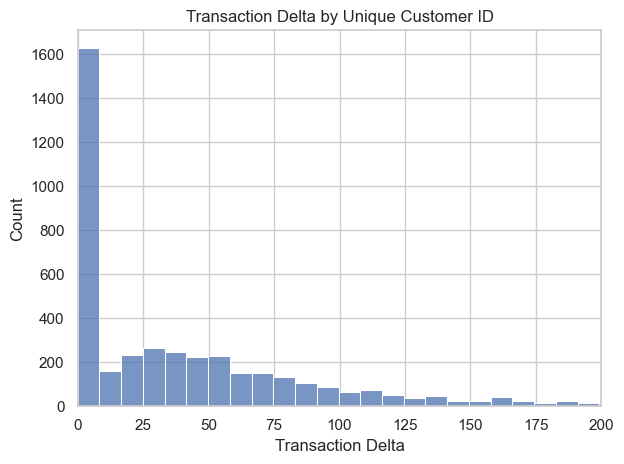

Most Occuring Time Delta Between Transactions: 0.0 Days


In [42]:
# Histogram on time delta between transactions by unique customer ids

time_delta_by_customer = df1.groupby('customer_id', as_index=False)['transaction_delta'].mean()

sns.set(style="whitegrid")
sns.histplot(data=time_delta_by_customer, x='transaction_delta')
plt.title('Transaction Delta by Unique Customer ID', fontsize=12)
plt.xlabel('Transaction Delta')
plt.xlim(0,200)
plt.tight_layout()

plt.savefig("plots/transaction_delta_count", dpi=200)

plt.show()

print("Most Occuring Time Delta Between Transactions:", time_delta_by_customer['transaction_delta'].mode()[0], "Days")

**Observation:** The majority of customers belong to the 0-day time delta group, which represents "one-and-done" customers, or customers who made all their transactions within a 12-hour window. Moving forward, we'd like to study the relationship with customer with at least a 1-day transaction-delta and above with total purchase frequency.

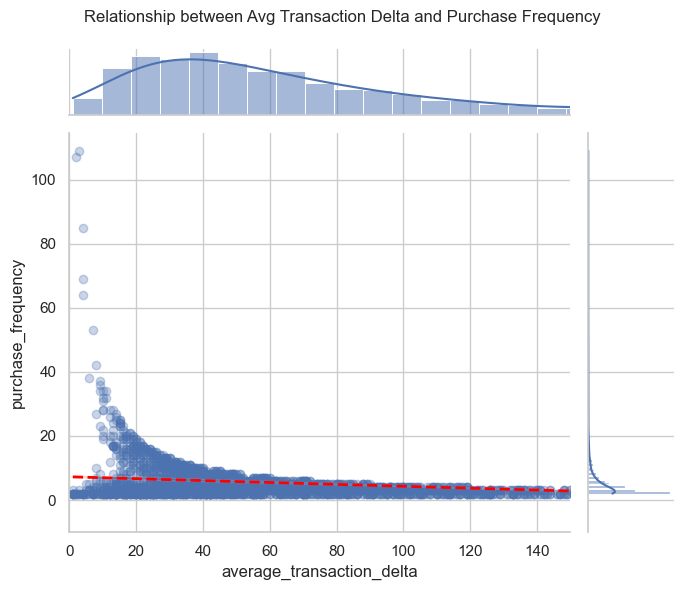

Spearman's Correlation Matrix for all time deltas


,average_transaction_delta,purchase_frequency
average_transaction_delta,1.00000,-0.44976
purchase_frequency,-0.44976,1.00000


Average Purchase Frequency Mean: 5.086874051593323
Average Purchase Frequency Median: 3.0
Average Purchase Frequency Mode: 2


In [43]:
# Visualizing a scatterplot on elapsed time between transactions and total purchase frequency
# Visualizing histogram of purchase frequency by customer ID's

delta_purchase_frequency = (df1
                            .query("transaction_delta > 0")
                            .groupby('customer_id').agg({'transaction_delta': 'mean', 'invoice_date': 'nunique'})
                            .rename(columns={'transaction_delta': 'average_transaction_delta', 'invoice_date': 'purchase_frequency'})
                           )
scatter_alpha = 0.3
linewidth = 2
figure_size = (7, 6)

sns.set(style="whitegrid")
joint = sns.jointplot(data=delta_purchase_frequency,
                      x='average_transaction_delta',
                      y='purchase_frequency',
                      kind='reg',
                      joint_kws={'scatter_kws': {'alpha': scatter_alpha},
                                 'line_kws': {'linewidth': linewidth, 'color': 'red', 'linestyle': '--'}},
                      height=figure_size[1])

joint.ax_joint.set_alpha(scatter_alpha)
joint.fig.set_figwidth(figure_size[0])
joint.fig.set_figheight(figure_size[1])
joint.ax_joint.set_xlim(0, 150)
plt.suptitle('Relationship between Avg Transaction Delta and Purchase Frequency', fontsize=12)
plt.tight_layout()

plt.savefig("plots/transact_delta_purchase_frequency", dpi=200)

plt.show()

print("Spearman's Correlation Matrix for all time deltas")
display(delta_purchase_frequency.corr(method='spearman'))
print("Average Purchase Frequency Mean:", delta_purchase_frequency['purchase_frequency'].mean())
print("Average Purchase Frequency Median:", delta_purchase_frequency['purchase_frequency'].median())
print("Average Purchase Frequency Mode:", delta_purchase_frequency['purchase_frequency'].mode()[0])

**Observations:** Amongst unique customers who had at least 2 transactions over their lifetime while taking at least 1 day or more between separate transactions, here are our findings &ndash; the overall Spearman's correlation coefficient matrix suggests there is a moderate negative correlation between Average Transaction Delta and Purchase Frequency. Our regression line tells a similar story, indicating a low-moderately increasing relationship when viewed from the right. However, when we view the scatterplot from the right starting from roughly a delta of 90 (3 months), our scatterplot starts to exhibit an increased incline before splitting into two groups towards the end, one that stays flat while the other increases linearly before ending parabolically/exponentially. 

> **Intermediate Conclusion:** Our hypothesis of "Customers with shorter time deltas between transactions are more likely to exhibit higher repeat purchase behavior, indicating higher engagement/loyalty" is accepted to a degree. The relationship is one of a non-linear nature and we observe low-moderate positive correlation for purchase frequency, the lower a customer's time delta. This trend starts to increase in density starting from the <u>90-day to 2-day time delta</u>.
<br><br>
> **N.B.** Transaction time delta will be used as a clustering feature, eventhough it has a relatively low overall impact.

In [44]:
# Engineering a feature for average time delta between transactions

df1.drop(columns={'transaction_delta'}, inplace=True)
df1 = df1.merge(time_delta_by_customer, on='customer_id', how='left')
df1['transaction_delta'] = df1['transaction_delta'].astype('int')
df1.rename(columns={'transaction_delta': 'avg_transact_delta'}, inplace=True)

[Back to Contents](#back)

<br>

## 3.7. Relationship Between Purchase Frequency & Future Purchase Frequency (Chi-Test)<a id='eda7'><a/>

**NOTE:** Testing the hypothesis that "purchase frequency (first order month) and average purchase frequency of proceeding months are likely dependent on each other."
- H0 &ndash; 'First month purchase frequency' is independent of 'Average purchase frequency proceeding the first month'.
- H1 &ndash; 'First month purchase frequency' is dependent of 'Average purchase frequency proceeding the first month'.

In [45]:
# Extracting first order months for each customer

first_order = df1.groupby('customer_id')['invoice_month'].min()
first_order.name = 'first_invoice_month'
first_order
df1 = df1.join(first_order, on='customer_id')

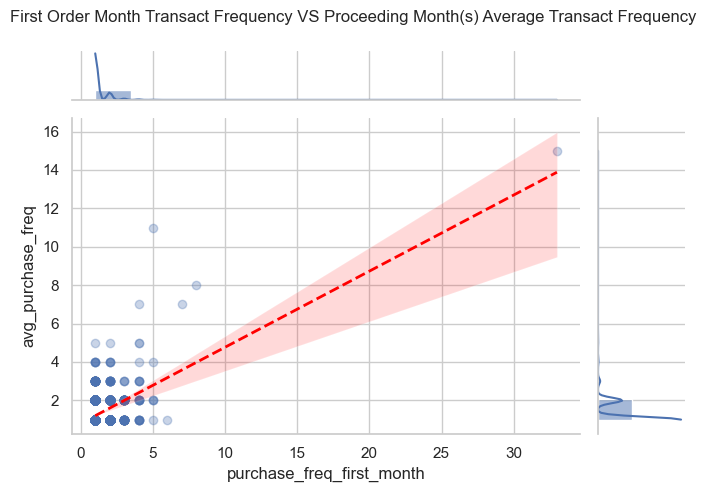

Spearman's Correlation Matrix:


,purchase_freq_first_month,avg_purchase_freq
purchase_freq_first_month,1.000000,0.200264
avg_purchase_freq,0.200264,1.000000


In [46]:
## Getting cohorts of purchase frequency by first month and over lifetime proceeding the first month period
## For users with at least 2 transactions over their lifetime

# Proceeding Month(s) Average Frequency table
purchase_freq = df1.query("invoice_month != first_invoice_month")
purchase_freq = purchase_freq.groupby(['customer_id', 'invoice_month'], as_index=False)['invoice_no'].nunique()
purchase_freq = (purchase_freq
                 .rename(columns={'invoice_no': 'avg_purchase_freq'})
                )
purchase_freq = purchase_freq.groupby('customer_id', as_index=False)['avg_purchase_freq'].mean()
purchase_freq['avg_purchase_freq'] = (purchase_freq['avg_purchase_freq'].round(0)).astype('int')

# First Month Frequency table
purchase_freq_first_month = df1[df1['invoice_month'] == df1['first_invoice_month']]
purchase_freq_first_month = purchase_freq_first_month.groupby(['customer_id',], as_index=False)['invoice_no'].nunique()
purchase_freq_first_month = (purchase_freq_first_month
                             .rename(columns={'invoice_no': 'purchase_freq_first_month'})
                            )
purchase_freq_first_month = purchase_freq_first_month.query("customer_id in @purchase_freq.customer_id")


# MAIN merged table
purchase_freq_total = purchase_freq_first_month.merge(purchase_freq, on='customer_id')

# Jointplot
scatter_alpha = 0.3
linewidth = 2
figure_size = (7, 5)

sns.set(style="whitegrid")
joint = sns.jointplot(data=purchase_freq_total,
                      x='purchase_freq_first_month',
                      y='avg_purchase_freq',
                      kind='reg',
                      joint_kws={'scatter_kws': {'alpha': scatter_alpha},
                                 'line_kws': {'linewidth': linewidth, 'color': 'red', 'linestyle': '--'}},
                      height=figure_size[1])

joint.ax_joint.set_alpha(scatter_alpha)
joint.fig.set_figwidth(figure_size[0])
joint.fig.set_figheight(figure_size[1])


plt.suptitle('First Order Month Transact Frequency VS Proceeding Month(s) Average Transact Frequency', fontsize=12)
plt.tight_layout()

plt.savefig("plots/first_transact_freq_vs_avg_transact_freq", dpi=200)

plt.show()

# Correlation Matrix
print("Spearman's Correlation Matrix:")
purchase_freq_total[['purchase_freq_first_month', 'avg_purchase_freq']].corr(method='spearman')


**Observations:** Our correlation coefficients suggest the relationship between first-month transaction frequencies and average lifetime transaction frequencies is one of very low positive correlation; we could even say that they are highly independent of each other. As for our joint plot, it exhibits a very scattered array of data points, showing near to no apparent correlation.

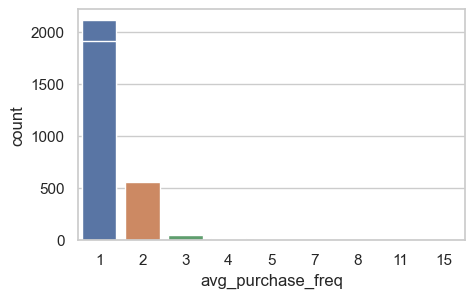

In [47]:
# Getting a perspective of possible purchase frequency categories we can create

plt.figure(figsize=(5,3))
sns.countplot(data=purchase_freq_total, x='purchase_freq_first_month')
sns.countplot(data=purchase_freq_total, x='avg_purchase_freq')
plt.show()

In [48]:
# Assigning categorical identifiers to purchase frequency values

"""
purchase_freq_dict = {
    (1): 'Low',
    (2): 'Moderate',
    (3): 'Frequent',
    (4): 'Very Frequent',
    (5, float('inf')): 'Extremely Frequent',
}
"""

purchase_freq_total['first_month_freq_id'] = pd.cut(
    purchase_freq_total['purchase_freq_first_month'], bins=[1, 2, 3, 4, 5, float('inf')], 
    labels=['Low', 'Moderate', 'Frequent', 'Very Frequent', 'Extremely Frequent'], right=False)

purchase_freq_total['avg_freq_id'] = pd.cut(
    purchase_freq_total['avg_purchase_freq'], bins=[1, 2, 3, 4, 5, float('inf')], 
    labels=['Low', 'Moderate', 'Frequent', 'Very Frequent', 'Extremely Frequent'], right=False)

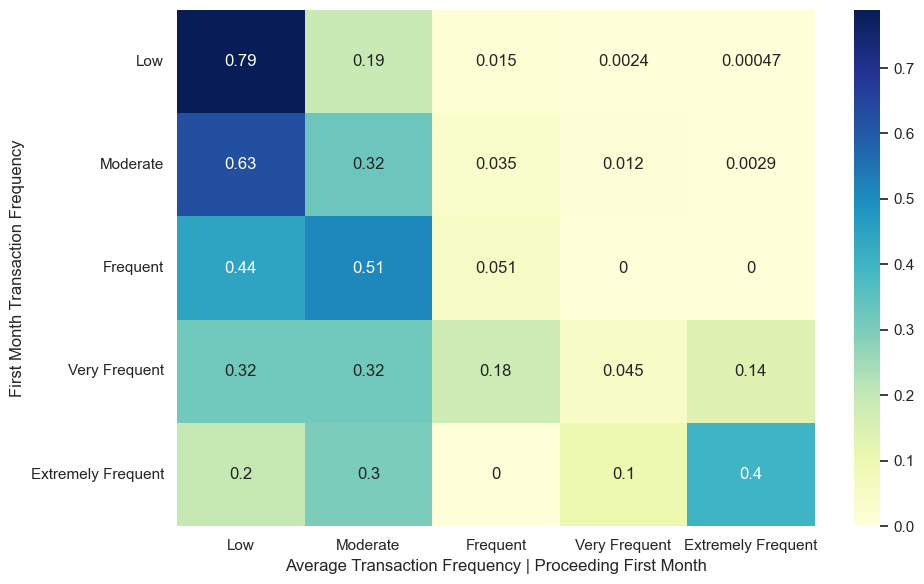

In [49]:
# Creating a contingency table

contigency= pd.crosstab(purchase_freq_total['first_month_freq_id'], 
                        purchase_freq_total['avg_freq_id'], 
                        normalize='index'
                       )
plt.figure(figsize=(10,6))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")
plt.xlabel('Average Transaction Frequency | Proceeding First Month', fontsize=12)
plt.ylabel('First Month Transaction Frequency', fontsize=12)
plt.tight_layout()

plt.savefig("plots/transact_freq_chi", dpi=200)

plt.show()

In [50]:
# Performing our chi test

c, p, dof, expected = chi2_contingency(contigency)
p

0.9999692702407253

**Observations:** Looking at our contingency table, to prove our Alternate Hypothesis (dependence of both variables) true, we'd like to see more deep blue cells across the middle diagonal. Unfortunately we did not, and the only dependent frequency group are those that purchased once a month in the first order-month and subsequently made an average of 1 purchase across their subsequent lifetime. Our Chi-Test's p-value of 99.9% also affirms our contingency table's results, as assuming a 5% statistical significance threshold, we have no reason to reject our Null hypothesis. Both variables are independent of one another.

> **Intermediate Conclusion:** Our hypothesis that "purchase frequency (first order month) and average purchase frequency of proceeding months are likely dependent on each other" is rejected. The only thing we may conclusively bet on, is that customers who purchase once in the first month, will likely commit to similar behaviour in proceeding months.

[Back to Contents](#back)

<br>

## 3.8. LTV x [Purchase Frequency | Purchase Value | Basket Size] <a id='eda8'><a/>

**NOTE:** Testing the hypothesis that -  
<br>
(1) "Purchase Frequency has a higher impact on LTV compared to Average Purchase Value and Average Basket Size" and
<br>
(2) "Customer segments differ in terms of their average basket size (average quantity) and average frequency of purchase".

In [51]:
# Extracting lifetime ages for each unique customer

df1['lifetime_max'] = df1.groupby('customer_id')['invoice_date'].transform(lambda x: x.max())
df1['lifetime_min'] = df1.groupby('customer_id')['invoice_date'].transform(lambda x: x.min())
df1['age_months'] = ((df1['lifetime_max'] - df1['lifetime_min']) / np.timedelta64(1, 'M')).round().astype('int')
df1['age_months'] = df1['age_months'].replace(0, 1)
df1.drop(['lifetime_max', 'lifetime_min'], axis=1, inplace=True)

In [52]:
# Calculating LTV, avg purchase frequency and avg purchase value

report = df1.groupby('customer_id', as_index=False).agg(
    {'invoice_no': 'nunique', 'quantity': 'count', 'revenue': 'sum', 'age_months': 'max'})
report.rename(columns={'invoice_no': 'n_purchases', 'quantity': 'n_quantities'}, inplace=True)
report['ltv'] = (report['revenue'] / report['age_months']).round(2)
report['avg_purchase_frequency'] = (report['n_purchases'] / report['age_months']).round(2)
report['avg_basket_size'] = (report['n_quantities'] / report['n_purchases']).round(2)
report['avg_purchase_value'] = (report['revenue'] / report['n_purchases']).round(2)
report.head()

,customer_id,n_purchases,n_quantities,revenue,age_months,ltv,avg_purchase_frequency,avg_basket_size,avg_purchase_value
0,12347,6,171,4085.18,11,371.38,0.55,28.50,680.86
1,12348,4,27,1437.24,9,159.69,0.44,6.75,359.31
2,12349,1,72,1457.55,1,1457.55,1.00,72.00,1457.55
3,12350,1,16,294.40,1,294.40,1.00,16.00,294.40
4,12352,7,77,1385.74,9,153.97,0.78,11.00,197.96


In [53]:
# Standardizing avg purchase frequency and avg invoice value to the same scale

columns_to_scale = ['avg_purchase_frequency', 'avg_purchase_value', 'avg_basket_size']
report_selected = report[columns_to_scale]

scaler = MinMaxScaler(feature_range=(0, 1))
X_st = scaler.fit_transform(report_selected)

report_st = pd.DataFrame(X_st, columns=columns_to_scale)
report_st = pd.concat([report_st, report.drop(columns_to_scale, axis=1)], axis=1)

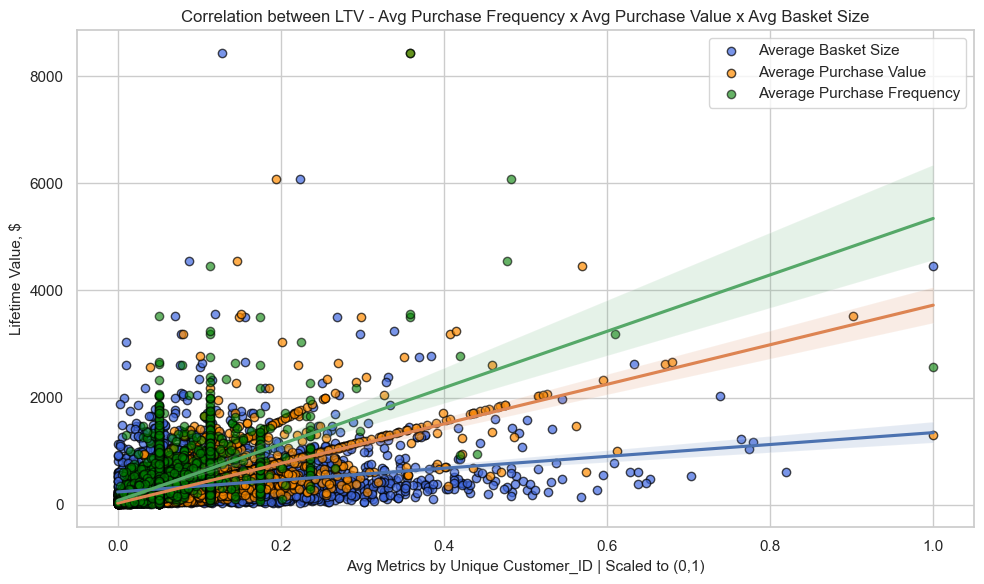

Spearman's Correlation Matrix


,ltv,avg_purchase_frequency,avg_purchase_value,avg_basket_size
ltv,1.000000,0.572037,0.755766,0.356349
avg_purchase_frequency,0.572037,1.000000,-0.040043,-0.063218
avg_purchase_value,0.755766,-0.040043,1.000000,0.475429
avg_basket_size,0.356349,-0.063218,0.475429,1.000000


In [54]:
# Visualizing a scatterplot and calculating correlation coefficients

plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.regplot(data=report_st, x='avg_basket_size', y='ltv', 
            scatter_kws={'alpha': 0.7, 'color': 'royalblue', 'edgecolor': 'black'}, label='Average Basket Size')
sns.regplot(data=report_st, x='avg_purchase_value', y='ltv', 
            scatter_kws={'alpha': 0.7, 'color': 'darkorange', 'edgecolor': 'black'}, label='Average Purchase Value')
sns.regplot(data=report_st, x='avg_purchase_frequency', y='ltv', 
            scatter_kws={'alpha': 0.6, 'color': 'green', 'edgecolor': 'black'}, label='Average Purchase Frequency')

plt.title('Correlation between LTV - Avg Purchase Frequency x Avg Purchase Value x Avg Basket Size', fontsize=12)
plt.xlabel('Avg Metrics by Unique Customer_ID | Scaled to (0,1)', fontsize=11)
plt.ylabel('Lifetime Value, $', fontsize=11)
plt.legend()
plt.tight_layout()

plt.savefig("plots/LTV_metrics_scatter", dpi=200)

plt.show()

# Constructing a correlation matrix
print("Spearman's Correlation Matrix")
report_st[['ltv', 'avg_purchase_frequency', 'avg_purchase_value', 'avg_basket_size']].corr(method='spearman')

**Observations:** Amongst our three metrics against Customer Lifetime Value, Average Purchase Value achieved the best positive correlation-coefficient score of 0.76, followed closely by Average Purchase Frequency at 0.57,  and lastly Average Basket Size with a low correlation of 0.36; this is depicted in our scatterplot, whereby our regression lineplots show the approximate direction of our metrics. Hence we will infer that both purchase frequency and purchase value have higher importance in both present and future LTV indication, with the latter taking precedence over ther other. 
<br><br>
A key observation we also noticed is that Average Basket Size has little to no relationship with Average Purchase Frequency. we would think that a much larger basket size would correlate with a lower need/want to purchase regularly, and vice versa with a smaller basket size equating to a more frequent need/want to purchase in the future. This does not seem to be the case.

> **Overall Observations:** Our scatterplot and correlation matrix showed us that Average Purchase Value had the most positive correlation with Lifetime Value, with Average Purchase Frequency attaining a medium positive correlation. These are great indicators to spot customers who need that extra personalization in their marketing. Basket size on the other had a relatively low correlation coefficient with LTV. We also noticed that Average Purchase Frequency had close to null correlation with Average Basket Size.

> **Intermediate Conclusion:** Our hypothesis that (1) "Purchase Frequency has a higher impact on LTV compared to Average Purchase Value and Average Basket Size" and (2) "Customer segments differ in terms of their average basket size (average quantity) and average frequency of purchase" has both been disproved. The Purchase Value metric is dominant, but Purchase Frequency still has great importance, while basket size has no predictive value towards Purchase Value (in a vacuum).
<br>
<br>
> **N.B.** We will proceed to engineer features for all 3 metrics. Though average basket size tends towards less correlation with LTV, its positive effects are still present and as such, will be included in our clustering algorithm. Features for customer lifetime ages and LTV will also be included in our clustering algorithm. There is however a doubt on whether they will lead to multicollinearity, so we will assess them in our feature correlation matrix later.

In [55]:
# Engineering features of Average Purchase Value, Average Purchase Frequency, Average Basket Size, Lifetime Age and LTV

metrics_to_merge = report.drop(['n_purchases', 'n_quantities', 'revenue'], axis=1)
df1 = df1.drop('age_months', axis=1)
df1 = df1.merge(metrics_to_merge, on='customer_id', how='left')
df1 = df1.rename(columns={'age_months': 'lifetime_age'})

[Back to Contents](#back)

<br>

## 3.9. Price Sensitivity &ndash; Feature Engineering <a id='eda9'><a/>

**NOTE:** In this section, we will engineer a feature of price sensitivity based on the 50th percentile value for average unit price by distinct customer_id's as our threshold.

In [56]:
# Aggregating data on average unit prices per customer
price_study = df1.groupby(['customer_id', 'invoice_no'], as_index=False).agg({'unit_price': 'mean'})
price_study = price_study.groupby('customer_id', as_index=False)['unit_price'].mean()
price_study['unit_price'] = (price_study['unit_price'].map('{:.2f}'.format)).astype('float')

# Getting percentiles of unique unit prices
print("Percentiles of Overall Unique Unit Prices")
print(np.percentile(df1.unit_price.unique(), [5, 25, 30, 50, 60, 75, 95], interpolation='nearest'))

Percentiles of Overall Unique Unit Prices
[ 0.18  1.    1.48  3.95  6.    9.95 50.  ]


In [57]:
# Assigning price sensitivity groups to our customers IDs 
# We will use the 50th percentile of overall unit price, rounded to the nearest integer as our threshold

"""
price_group_dict = {
    (0, 4): 1,
    (4.1, float('inf')): 0,
}
"""

price_study['price_sensitive'] = pd.cut(
    price_study['unit_price'],
    bins=[0, 4, float('inf')],
    labels=[1, 0],
    right=False
)

price_study['price_sensitive'] = price_study['price_sensitive'].astype('int')

In [58]:
# One hot encoding for price sensitvity

price_study = price_study.drop('unit_price', axis=1)
df1 = df1.merge(price_study[['customer_id', 'price_sensitive']], on='customer_id', how='left')

[Back to Contents](#back)

<br>

# Conclusions on EDA <a id='edaconclusion'><a/>

    
<u>Outlier Treatment:</u> Summary of outlier processing.
* Partial months of November 18' and December 19' were removed. This gave us a strict 12-month time frame for analysis.
* Purchase Value by Unique Invoices - Median average of \\$300 with a right skewed distribution, indicating subsets of customers who are bulk buyers. Filtered out data based on customers who possessed outlier invoices with purchase value above \\$6207. 
* Basket Size by Unique Invoice - Median average of 152 total item quantity for a typical invoice, with a right skewed distribution that indicates subsets of customers who are bulk buyers. Filtered out data based on customers who possessed invoices above a basket size of 2048.
<br>
    
<u>Features Engineering:</u> These are the features we constructed for segmenting purposes.   
* Seasonal shoppers
* Transaction time delta
* Average purchase value
* Average purchase frequency
* Average basket size
* Lifetime Value (LTV)
* Price sensitivity

[Back to Contents](#back)

<br>

# 4. Recency Frequency Monetary (RFM) Segmentation <a id='rfm' ><a/>


This section identifies the exact customers who the client should be targeting for personalized retention marketing, the amount of additional marketing budget a particular segment would require and who our best customers are such that they can provide more loyalty-based benefits.

## 4.1. RFM Score Calculations <a id='rfm1' ><a/>

In [59]:
# Extracting only necessary features for RFM analysis

rfm_data = df1[['invoice_no', 'invoice_date', 'revenue', 'customer_id']]
rfm_data.head()

,invoice_no,invoice_date,revenue,customer_id
0,536847,2018-12-01,20.16,17135
1,536847,2018-12-01,15.12,17135
2,536847,2018-12-01,15.60,17135
3,536847,2018-12-01,34.80,17135
4,536847,2018-12-01,15.00,17135


In [60]:
### Generating our RFM table

# getting an arbitrary date that proceeds the last observed transaction by 1 day
NOW = rfm_data['invoice_date'].max() +  pd.DateOffset(days=1) 

#RFM table construction
RFM_df = rfm_data.groupby('customer_id', as_index=False).agg({
    'invoice_date': lambda x: (NOW - x.max()).days,
    'invoice_no': lambda x: len(x.unique()),
    'revenue': lambda x: x.sum()
    })
RFM_df['invoice_date'] = RFM_df['invoice_date'].astype('int')
RFM_df.rename(columns={'invoice_date': 'recency', 'invoice_no': 'frequency', 'revenue': 'monetary'}, inplace=True)
display(RFM_df.head())

# Calculating quantiles for each feature, converting to a dict for ease of access
quantiles = RFM_df.quantile(q=[0.25,0.5,0.75])
display(quantiles)
quantiles_dict = quantiles.to_dict()
quantiles_dict

,customer_id,recency,frequency,monetary
0,12347,33,6,4085.18
1,12348,69,4,1437.24
2,12349,12,1,1457.55
3,12350,304,1,294.40
4,12352,30,7,1385.74


,customer_id,recency,frequency,monetary
0.25,13825.0,16.5,1.0,298.99
0.50,15303.0,50.0,2.0,638.98
0.75,16783.0,142.0,4.0,1516.12


{'customer_id': {0.25: 13825.0, 0.5: 15303.0, 0.75: 16783.0},
 'recency': {0.25: 16.5, 0.5: 50.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0},
 'monetary': {0.25: 298.99, 0.5: 638.98, 0.75: 1516.12}}

> **N.B.** *We will proceed to use our quantiles dictionary to create segmentation groups. The R class (Recency) is done separately from the F(Frequency) and M(Monetary) classes as a high R value equates to a large time delta since a particular customer's last transaction.*

In [61]:
### Segmenting customers based on feature quartiles

# Recency Scores
## Arguments - (x=data, p= RECENCY feature, d=dicationary)
### N/B: higher score is better
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Frequency and Monetary Scores
## Arguments - (x=data, p= FREQUENCY/MONETARY feature, d=dicationary)
### N/B: higher score is better
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
      
# Assigning score identifiers 
RFM_groups = RFM_df
RFM_groups['recency_score'] = RFM_groups['recency'].apply(RScore, args=('recency', quantiles_dict))
RFM_groups['frequency_score'] = RFM_groups['frequency'].apply(FMScore, args=('frequency', quantiles_dict))
RFM_groups['monetary_score'] = RFM_groups['monetary'].apply(FMScore, args=('monetary', quantiles_dict)) 
RFM_groups.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,12347,33,6,4085.18,3,4,4
1,12348,69,4,1437.24,2,3,3
2,12349,12,1,1457.55,4,1,3
3,12350,304,1,294.40,1,1,1
4,12352,30,7,1385.74,3,4,3


> **N.B.** *RFM Scores - HIGHER IS BETTER.*

In [62]:
# Concatenating r + f + m to get our consoliated RFM score

RFM_groups['rfm_score'] = (RFM_groups['recency_score'].astype(str) + 
                           RFM_groups['frequency_score'].astype(str) + 
                           RFM_groups['monetary_score'].astype(str))
RFM_groups                           

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
0,12347,33,6,4085.18,3,4,4,344
1,12348,69,4,1437.24,2,3,3,233
2,12349,12,1,1457.55,4,1,3,413
3,12350,304,1,294.40,1,1,1,111
4,12352,30,7,1385.74,3,4,3,343
...,...,...,...,...,...,...,...,...
4198,18280,271,1,180.60,1,1,1,111
4199,18281,174,1,80.82,1,1,1,111
4200,18282,1,2,178.05,4,2,1,421
4201,18283,3,15,1831.58,4,4,4,444


[Back to Contents](#back)

<br>

## 4.2. Customer Segments by RFM Scores <a id='rfm2' ><a/>

**i. <u>Who are the client's best customers?</u>**

In [63]:
display(RFM_groups.query("rfm_score == '444'").sort_values('monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
531,13089,2,95,54694.80,4,4,4,444
3894,17841,1,121,38169.97,4,4,4,444
2600,16013,1,46,36339.56,4,4,4,444
308,12748,1,197,30783.31,4,4,4,444
539,13098,3,25,26516.68,4,4,4,444
759,13408,2,59,26229.52,4,4,4,444
1901,15039,3,47,19766.59,4,4,4,444
3779,17675,2,30,19645.36,4,4,4,444
3600,17428,16,27,16841.25,4,4,4,444
1995,15159,12,27,16806.22,4,4,4,444


**ii. <u>Who are high potential customers?</u>**

In [64]:
display(RFM_groups.query("recency_score >= 3 and frequency_score == 3 and monetary_score >= 3").sort_values(
    'monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
2975,16532,11,3,6748.80,4,3,4,434
2683,16126,23,4,6287.77,3,3,4,334
1212,14049,10,4,5578.72,4,3,4,434
143,12539,16,4,5568.35,4,3,4,434
2808,16303,19,3,5360.63,3,3,4,334
1372,14286,17,3,4628.75,3,3,4,334
271,12700,1,4,4525.99,4,3,4,434
64,12432,36,4,4359.32,3,3,4,334
1367,14277,9,3,4152.00,4,3,4,434
1135,13941,15,4,4017.84,4,3,4,434


**iii. <u>Who are the most loyal customers?</u>**

In [65]:
display(RFM_groups.query("frequency_score == 4").sort_values('monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
531,13089,2,95,54694.80,4,4,4,444
3894,17841,1,121,38169.97,4,4,4,444
2600,16013,1,46,36339.56,4,4,4,444
308,12748,1,197,30783.31,4,4,4,444
1654,14680,19,16,28754.11,3,4,4,344
539,13098,3,25,26516.68,4,4,4,444
759,13408,2,59,26229.52,4,4,4,444
1901,15039,3,47,19766.59,4,4,4,444
3779,17675,2,30,19645.36,4,4,4,444
298,12731,17,12,18751.91,3,4,4,344


**iv. <u>Who are the biggest spenders?</u>**

In [66]:
display(RFM_groups.query("monetary_score == 4").sort_values(
    'monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
531,13089,2,95,54694.80,4,4,4,444
3894,17841,1,121,38169.97,4,4,4,444
2600,16013,1,46,36339.56,4,4,4,444
308,12748,1,197,30783.31,4,4,4,444
1654,14680,19,16,28754.11,3,4,4,344
539,13098,3,25,26516.68,4,4,4,444
759,13408,2,59,26229.52,4,4,4,444
1901,15039,3,47,19766.59,4,4,4,444
3779,17675,2,30,19645.36,4,4,4,444
298,12731,17,12,18751.91,3,4,4,344


**v. <u>Who are lost cheap customers?</u>**

In [67]:
display(RFM_groups.query("rfm_score == '111'").sort_values(
    'monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
104,12489,330,1,298.93,1,1,1,111
2321,15609,178,1,298.48,1,1,1,111
3782,17678,257,1,298.11,1,1,1,111
394,12881,269,1,298.00,1,1,1,111
3675,17531,184,1,296.70,1,1,1,111
1000,13751,282,1,296.25,1,1,1,111
333,12790,186,1,294.92,1,1,1,111
3,12350,304,1,294.40,1,1,1,111
3392,17124,179,1,294.24,1,1,1,111
3103,16721,256,1,292.47,1,1,1,111


**vi. <u>Who are lost valuable customers?</u>**

In [68]:
display(RFM_groups.query("rfm_score == '144'").sort_values('monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
458,12980,151,9,7374.90,1,4,4,144
535,13093,269,7,7033.07,1,4,4,144
2986,16553,157,12,5719.82,1,4,4,144
2150,15379,163,7,3703.29,1,4,4,144
3462,17230,258,8,3638.41,1,4,4,144
3651,17504,200,9,2997.03,1,4,4,144
4184,18260,166,6,2628.35,1,4,4,144
3249,16919,150,11,2592.25,1,4,4,144
2048,15235,211,11,2168.01,1,4,4,144
4165,18231,186,5,2071.77,1,4,4,144


**vii. <u>Who are valuable customers who are almost lost?</u>**

In [69]:
display(RFM_groups.query("rfm_score == '244'").sort_values('monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
432,12939,58,8,11581.80,2,4,4,244
2724,16180,94,8,10254.18,2,4,4,244
1840,14952,53,11,8099.49,2,4,4,244
3120,16745,80,17,7180.70,2,4,4,244
3052,16652,52,7,6773.97,2,4,4,244
2551,15939,83,15,6115.01,2,4,4,244
3656,17509,51,8,6083.64,2,4,4,244
319,12766,51,6,5851.20,2,4,4,244
223,12637,61,8,5804.90,2,4,4,244
3214,16873,55,5,5268.79,2,4,4,244


**viii. <u>Who are new customers?</u>**

In [70]:
display(RFM_groups.query("recency_score == 4 and frequency_score == 1 and monetary_score <= 2").sort_values(
    'monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
242,12658,12,1,632.05,4,1,2,412
3993,17985,16,1,631.35,4,1,2,412
196,12603,15,1,613.20,4,1,2,412
2346,15645,12,1,611.59,4,1,2,412
1652,14675,10,1,596.36,4,1,2,412
3874,17806,5,1,546.04,4,1,2,412
2268,15539,1,1,538.46,4,1,2,412
329,12784,9,1,476.82,4,1,2,412
98,12479,5,1,473.20,4,1,2,412
2404,15721,5,1,471.40,4,1,2,412


**ix. <u>Who are occasional buyers?</u>** 

In [71]:
display(RFM_groups.query("recency_score <= 2 and frequency_score <= 2").sort_values('monetary', ascending=False).head(10))
print()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
66,12435,73,2,7829.890,2,2,4,224
3294,16984,82,2,4459.520,2,2,4,224
311,12755,274,2,3811.950,1,2,4,124
2780,16253,60,2,3683.860,2,2,4,224
1142,13952,211,2,3251.071,1,2,4,124
314,12758,110,2,2791.590,2,2,4,224
1480,14439,313,1,2661.240,1,1,4,114
769,13422,58,1,2626.300,2,1,4,214
215,12625,205,2,2413.820,1,2,4,124
3612,17444,145,2,2389.100,1,2,4,124


[Back to Contents](#back)

<br>

# 5. Unsupervised Learning - Segmentation by Clustering<a id='ml' ><a/>

## 5.1. Feature Selection - Avoiding Multicollinearity <a id='ml1' ><a/>

In [72]:
# Getting relevant features for each distinct customer ID

cluster_report = (df1
                  .groupby('customer_id', as_index=False)
                  .agg({'lifetime_age': 'max', 'avg_transact_delta': 'max',
                        'price_sensitive': 'max', 'seasonal_shopper': 'max', 
                        'avg_purchase_frequency': 'max', 'avg_purchase_value': 'max',
                        'avg_basket_size': 'max', 'ltv': 'max'})
                 )

# Dropping but retaining customer_id's

cluster_ids = cluster_report['customer_id']
cluster_report = cluster_report.drop('customer_id', axis=1)

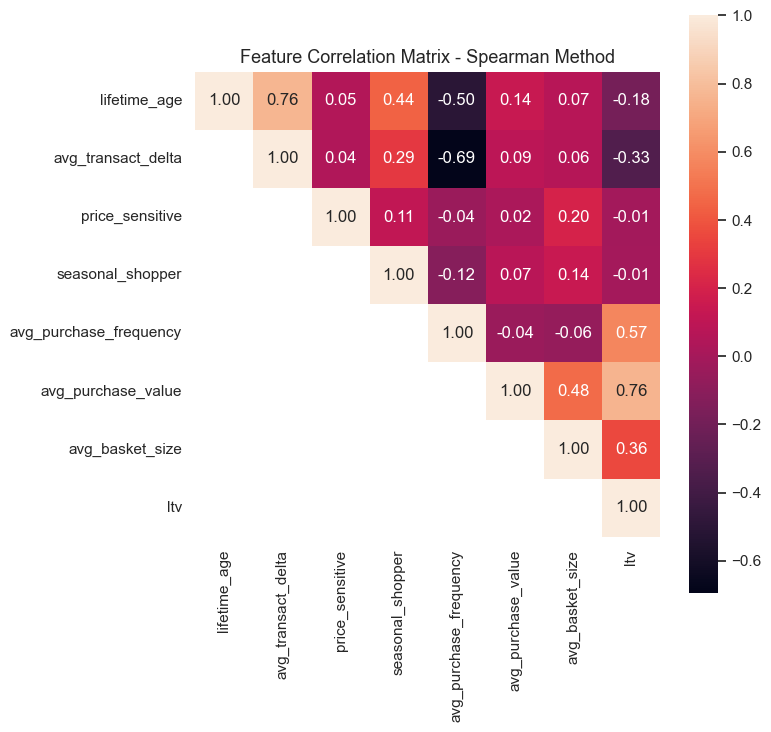

In [73]:
# Constructing a correlation matrix

cm_spear = cluster_report.corr(method='spearman')
n = cm_spear.shape[0]
mask = np.tri(n, k=-1, dtype=bool)
cm_spear = cm_spear.mask(mask)


# Converting correlation matrix into a heatmap

fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
sns.heatmap(cm_spear, annot = True, square=True, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Matrix - Spearman Method', fontsize=13)
plt.show()

**Observation:** We will set a threshold of 0.8 correlation coefficient as our threshold for multicollinearity. Apart from the moderately-high correlated feature-pairs of Average Purchase Valye/LTV and Lifetime Age/Average Transaction Delta, all other feature pairs exhibit low multicollinearity. Overall, no feature pair has crossed beyond our threshold. This is a perfect base for our K-Means clustering model, as each feature is independent in nature (to a degree) and will provide varying aspects of segmentation information.

[Back to Contents](#back)

<br>

## 5.2. Hierarchical Clustering for Estimation of K&ndash;clusters<a id='ml2' ><a/>

In [74]:
## Feature standardization - excluding one-hot encoded categorical features

scaler = StandardScaler()

# features to be standardized
features_numerical = cluster_report.drop([
    'price_sensitive', 'seasonal_shopper'], axis=1)  

# features to be left alone
features_categorical = cluster_report[[
    'price_sensitive', 'seasonal_shopper']] 

# Standardizing numerical feature matrix
features_numerical_st = pd.DataFrame(scaler.fit_transform(features_numerical), 
                                     columns=features_numerical.columns, index=features_numerical.index)

# Merging standardized numerical features matrix with categorical features
X_st = pd.merge(features_numerical_st, features_categorical, left_index=True, right_index=True)

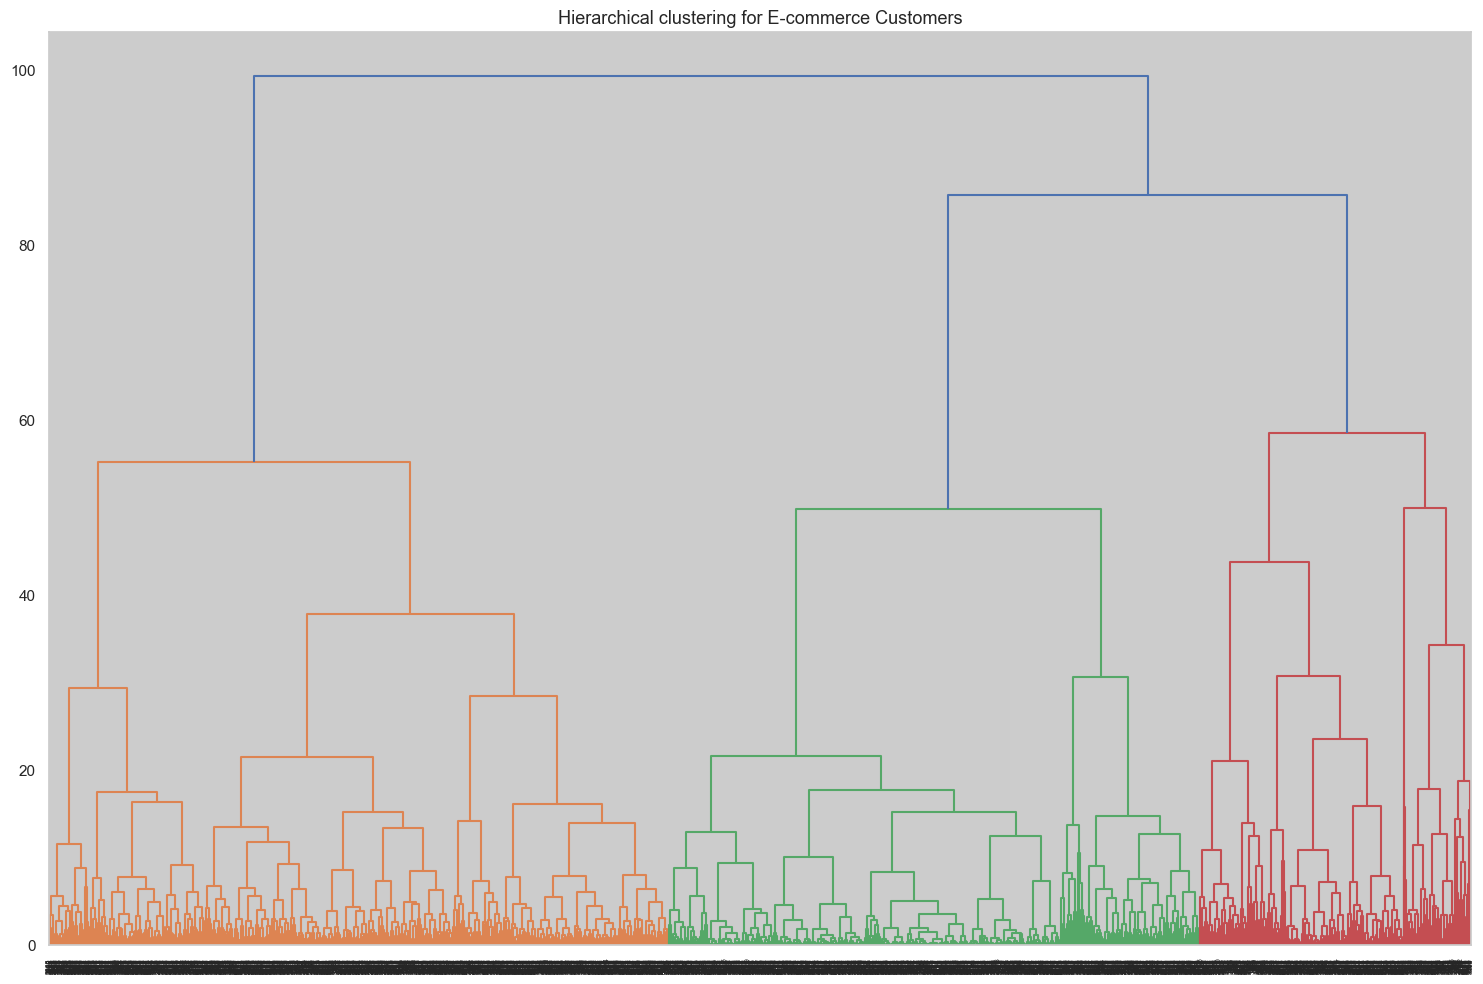

In [75]:
# Creating a linkage matrix of features
linkage_matrix = linkage(X_st, method='ward')

# Constructing a dengogram of our linkage matrix
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, orientation='top')
plt.title('Hierarchical clustering for E-commerce Customers', fontsize='13')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show() 

**Observations:** Our dendogram indicates an optimum K-clusters of 3. We will use this as a benchmark to determine our optimal number of clusters to use when performing our K-Means algorithm.

[Back to Contents](#back)

## 5.3. K-Means Clustering <a id='ml3' ><a/>

In [76]:
# Optimizing K-clusters
# Calculating simultaneous silhouette and inertia scores

sil = []
inertia = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_st)
    labels = kmeans.labels_
    sil_score = silhouette_score(X_st, labels, metric='euclidean')
    inertia_score = kmeans.inertia_
    sil.append(sil_score)
    inertia.append(inertia_score)

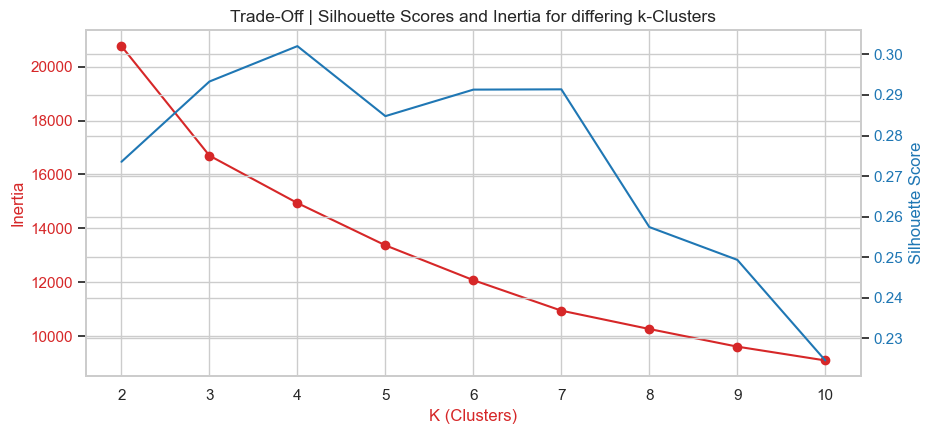

Inertia Scores: [20761.34285350307, 16697.323527700657, 14937.046334839366, 13367.648536376433, 12075.14734658569, 10942.994353874046, 10261.468300022874, 9607.075198616401, 9094.44326545214]
Silhouette Scores: [0.27352942417067916, 0.2933173209741393, 0.3020463566779006, 0.28478665705632283, 0.291323303874553, 0.29139207159984004, 0.25743390167706465, 0.24934853998472276, 0.22454653786280418]


In [77]:
# Visualizing the various inertia and silhouette scores as data points on a dual-axis line plot

k_clusters = range(2, kmax + 1)

fig, ax1 = plt.subplots()
fig.set_figheight(4.5)
fig.set_figwidth(9.5)


ax1.set_title('Trade-Off | Silhouette Scores and Inertia for differing k-Clusters', fontsize=12.5)

color = 'tab:red'
ax1.set_xlabel('K (Clusters)', color=color)
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_clusters, inertia, marker = 'o', color=color) # Assigning range of clusters to x-axis, INERTIA values to the LEFT y-axis
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_clusters, sil, color=color) # Assigning range of clusters to x-axis, SILHOUETE scores to the RIGHT y-axis
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

print("Inertia Scores:", inertia)
print("Silhouette Scores:", sil)

**Observation**: Our inertia plot indicates that BEYOND k=3, inertia scores start to transition towards a plateau; this is our elbow point. This coincides with the 2nd best Silhouette score 0.293 and as such, we can confirm the hierarchical clustering algorithm's suggestion of K=3. This will be used to train our K-Means model.

In [78]:
# Training our K-Means model of 3 clusters

km = KMeans(n_clusters=3, n_init=20, random_state=0)
labels = km.fit_predict(X_st)

cluster_report['customer_segment'] = labels   # assigning our labels to our DataFrame

In [79]:
# Sorting our segments by highest LTV to lowest

ltv_by_segment = cluster_report.groupby('customer_segment')['ltv'].mean()
sorted_segments = ltv_by_segment.sort_values(ascending=False).index
segment_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_segments)}
cluster_report['customer_segment'] = cluster_report['customer_segment'].replace(segment_mapping) + 1
cluster_report.groupby('customer_segment').mean()

,lifetime_age,avg_transact_delta,price_sensitive,seasonal_shopper,avg_purchase_frequency,avg_purchase_value,avg_basket_size,ltv
customer_segment,,,,,,,,
1,3.428571,21.093817,0.818763,0.682303,1.694392,821.116247,42.429041,1123.353284
2,1.497505,10.719062,0.747006,0.443613,1.204551,247.058762,17.214805,289.317290
3,8.127168,93.886127,0.818497,0.833526,0.641503,331.051370,21.447861,211.757786


[Back to Contents](#back)

<br>

**Consolidating our final report:**

In [80]:
# Re-merging our customer Id's
cluster_report = cluster_report.join(cluster_ids)

# Merging cluster report with RFM classes
final_report = cluster_report.merge(RFM_groups, on='customer_id')

[Back to Contents](#back)

<br>

## 5.4. Interpreting K-Means Results <a id='ml4' ><a/>

**NOTE:** *Customer segments are sorted by highest to lowest LTV (1 - 3)*

**NOTE 2:** *Our silhouette score was 0.293. This is not the best, and hence some unoptimal clustering of customers is expected.*

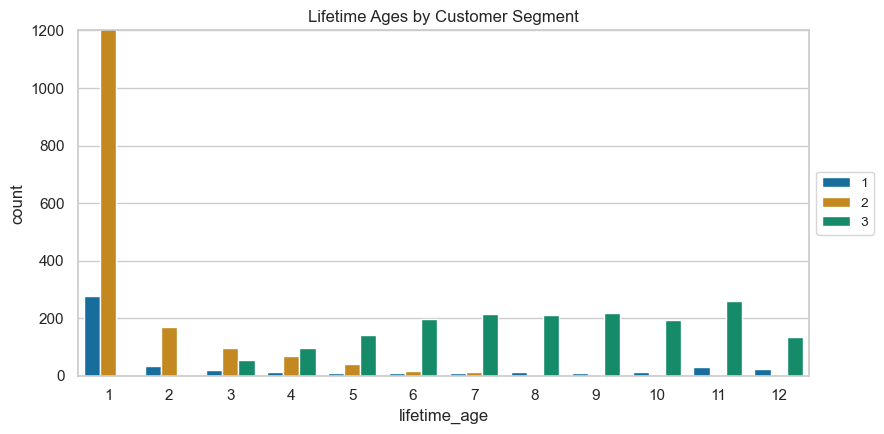

In [81]:
# Lifetime Age

barplot_feature_cluster(cluster_report, 'lifetime_age', ylim=(0,1200), figsize=(9, 4.5), 
                        title='Lifetime Ages by Customer Segment')

plt.savefig("plots/km_lifetime_age", dpi=200)

**Observations:** 

First off, we can observe the smaller amount of observations for Segment 1. These customers are those with relatively larger values for LTV, and assume the title of bulk/large basket size purchasers by default. Their lifetime values are concentrated in the 1-month age, but are consistently seen across all lifetime month intervals. One thing that stands out the most to us, is that the majority of segment 2 fall into the 1-month lifetime group. Observations for this group declines rapidly from 2 months onward. Lastly, segment 3 has the longest lifetime values, although it should be noted their LTV is lowest amongst our 3 segments. This could represent customers who are periodic/occasional shoppers who are loyal to the brand.

[Back to Contents](#back)

<br>

Average Transaction Delta mean values:


customer_segment
1    21.09
2    10.72
3    93.89
Name: avg_transact_delta, dtype: float64

Average Transaction Delta median values:


customer_segment
1    12.0
2     0.0
3    75.0
Name: avg_transact_delta, dtype: float64

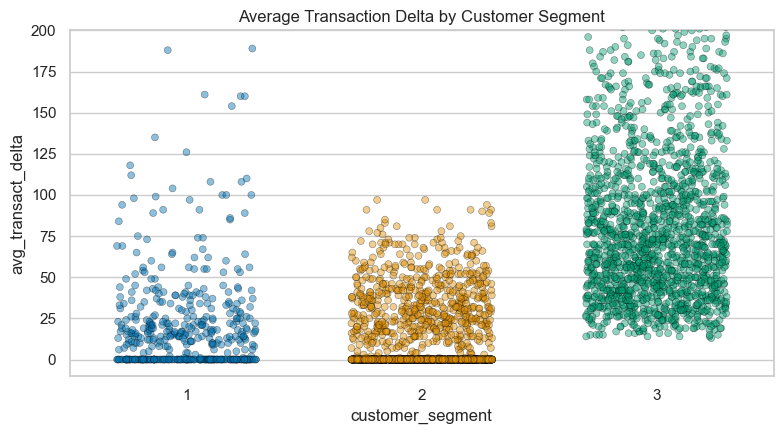

In [82]:
# Average transaction time delta

strip_plot_cluster(cluster_report, 'avg_transact_delta', alpha=0.45, jitter=0.3, 
                   linewidth=0.4, ylim=(-10,200), figsize=(8, 4.5),
                  title='Average Transaction Delta by Customer Segment')
plt.savefig("plots/km_trans_delta", dpi=200)

print('\033[1mAverage Transaction Delta mean values:')
display((cluster_report.groupby('customer_segment')['avg_transact_delta'].mean()).round(2))
print('\033[1mAverage Transaction Delta median values:')
(cluster_report.groupby('customer_segment')['avg_transact_delta'].median()).round(2)

# **Observations:** 

Segments 1 (21-day avg) and 2 (10.7-day avg) contain large amounts of users who transact below a 1-day time delta. These are customers who are **one-and-done shoppers**, as observed in our Lifetime Age graph. Apart from this, notice the dispersion of values occuring which suggests the type of behaviour that is seen in **periodic shoppers**. This observation is significantly more evident in segment 1, where we can see much more dispersion after the 50 day time delta. One caveat to note, is that segment 1 has a relatively lower sample size compared to other segments. Overall, segments 1 and 2 have significantly lower transaction time delta between purchases. Segment 3 (94-day avg) has consistently larger average transaction deltas and extreme amounts of variation in its time delta observations. They do not however, have any one-and-done shoppers, and they could potentially be shoppers who are **innately loyal** to an extent, and looking at their mean delta values, could also represent customers who are **periodic shoppers**. 

[Back to Contents](#back)

<br>

Price Sensitivity mean values:


customer_segment
1    0.82
2    0.75
3    0.82
Name: price_sensitive, dtype: float64

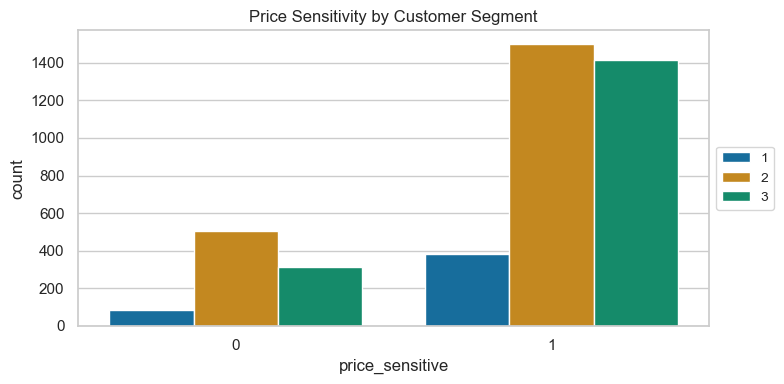

In [83]:
# Price Sensitive

barplot_feature_cluster(cluster_report, 'price_sensitive', figsize=(8,4),
                        title='Price Sensitivity by Customer Segment')
plt.savefig("plots/km_price_sensitive", dpi=200)

print('\033[1mPrice Sensitivity mean values:')
display((cluster_report.groupby('customer_segment')['price_sensitive'].mean()).round(2))

**Observations:** Looking at the mean values for price sensitivity: Segment 2 is the least price sensitive comparatively (75% segment share). If we remove Segment 1 (highest LTV but low sample size) and compare segments 2 and 3 in a vacuum, the lower price sensitivity for segment 2 checks out with its higher LTV. Segment 1 and 3 (82% segment share) are innately similar in their price sensitivity, though there is a stark difference in their LTV values (Segment 1 LTV - \\$1123, Segment 2 LTV - \\$212).

[Back to Contents](#back)

<br>

Seasonal Shopper mean values:


customer_segment
1    0.68
2    0.44
3    0.83
Name: seasonal_shopper, dtype: float64

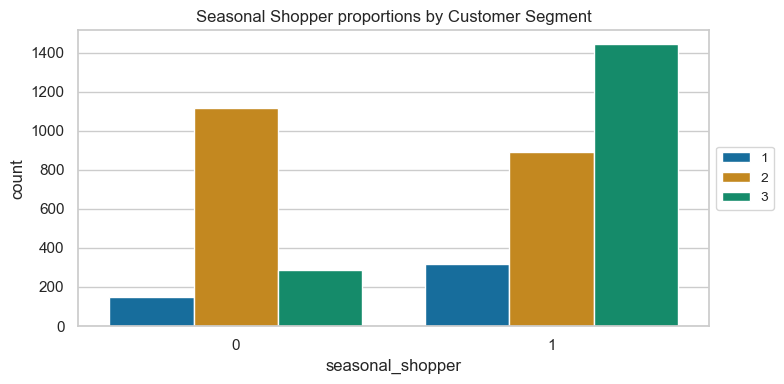

In [84]:
# Seasonal shopppers

barplot_feature_cluster(cluster_report, 'seasonal_shopper', figsize=(8,4),
                        title='Seasonal Shopper proportions by Customer Segment')
plt.savefig("plots/km_seasonal_shopper", dpi=200)

print('\033[1mSeasonal Shopper mean values:')
display((cluster_report.groupby('customer_segment')['seasonal_shopper'].mean()).round(2))

**Observations:** If we purely observe our mean values, segment 3 comprises customers who rely on seasonal bargains for their shopping needs at a 83% share, followed closely by segment 1 at a 68% share. Segment 2 stands out to us, as its customers have the least seasonal shopper proportion at a 44% share. This ties in with our price sensitivity graph, which showed segment 2 being the least price sensitive amongst all segments.

[Back to Contents](#back)

<br>

Avg Monthly Purchase Frequency mean values:


customer_segment
1    1.69
2    1.20
3    0.64
Name: avg_purchase_frequency, dtype: float64

Avg Monthly Purchase Frequency median values:


customer_segment
1    1.00
2    1.00
3    0.57
Name: avg_purchase_frequency, dtype: float64

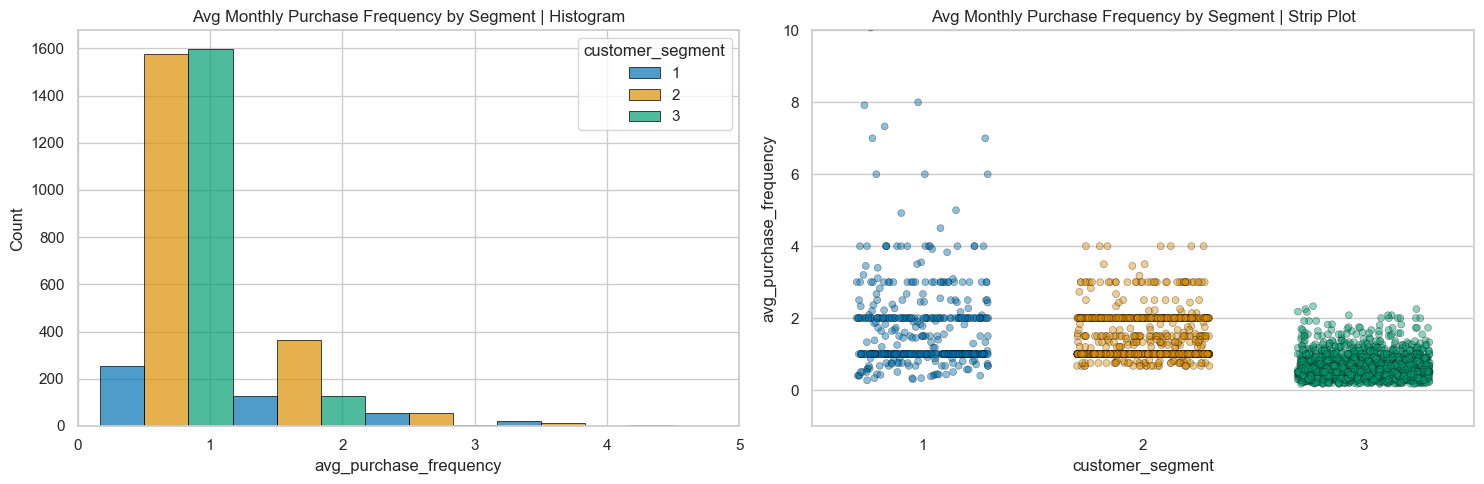

In [85]:
## Average Purchase Frequency

# Creating custom bins
x = cluster_report['avg_purchase_frequency']
w = 1
custom_bins=np.arange(min(x), max(x) + w, w)


# Plot(s)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

histplot_cluster(cluster_report, 'avg_purchase_frequency', xlim=(0, 5),
                   bins=custom_bins, 
                   title='Avg Monthly Purchase Frequency by Segment | Histogram', ax=ax1)

strip_plot_cluster(cluster_report, 'avg_purchase_frequency',
                   alpha=0.45, jitter=0.3, linewidth=0.4, ylim=(-1, 10), 
                   title='Avg Monthly Purchase Frequency by Segment | Strip Plot', ax=ax2)

plt.savefig("plots/km_avg_purchase_freq", dpi=200)

print('Avg Monthly Purchase Frequency mean values:')
display((cluster_report.groupby('customer_segment')['avg_purchase_frequency'].mean()).round(2))
print('Avg Monthly Purchase Frequency median values:')
(cluster_report.groupby('customer_segment')['avg_purchase_frequency'].median()).round(2)

**Observations:** Average purchase frequency for segment 1 and 2 are roughly similar at median values with 1 purchase a month, though looking at their mean values, segment 1 has higher variance towards the upper end and this is succinctly depicted in our scatterplot. Segment 3 as noted before, resembles customers who are periodic shoppers and this is once again seen here, averaging less than 1 transaction per month. Our of our 2 segments with high sample size (2 and 3), segment 2 leads all segments in the twice-a-month frequency group and beyond that, which is something noteworthy.

[Back to Contents](#back)

<br>

Avg Purchase Value mean values:


customer_segment
1    821.12
2    247.06
3    331.05
Name: avg_purchase_value, dtype: float64

Avg Purchase Value median values:


customer_segment
1    722.19
2    222.25
3    299.87
Name: avg_purchase_value, dtype: float64

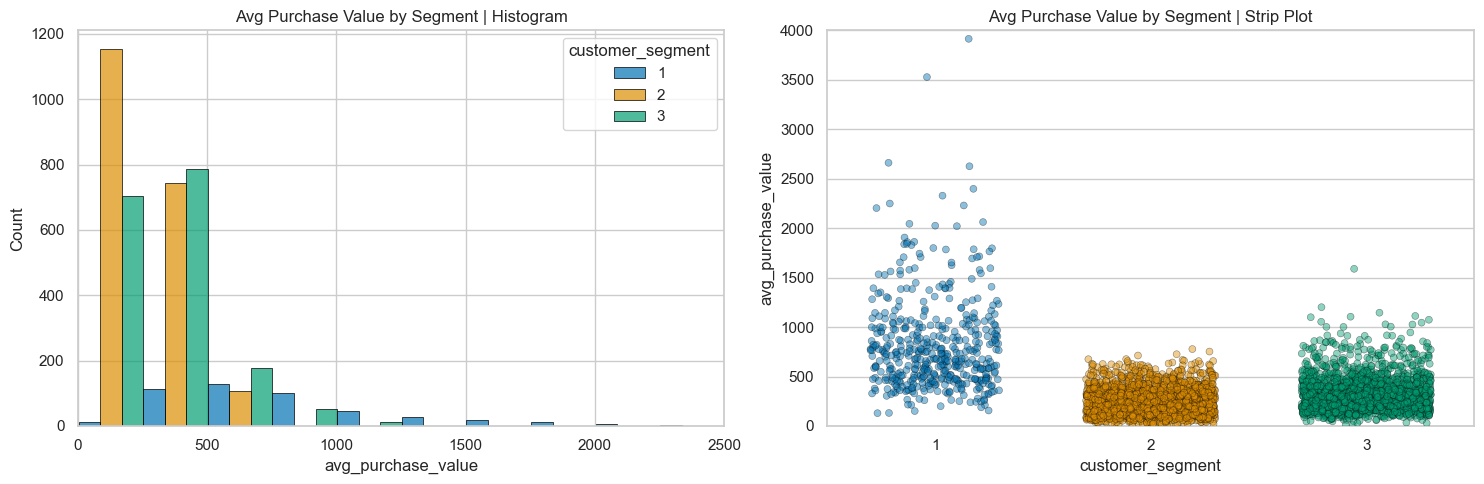

In [86]:
## Average Purchase Value

# Creating custom bins
x = cluster_report['avg_purchase_value']
w = 250
custom_bins=np.arange(min(x), max(x) + w, w)


# Plot(s)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

histplot_cluster(cluster_report, 'avg_purchase_value',
                   bins=custom_bins, xlim=(0, 2500),
                   title='Avg Purchase Value by Segment | Histogram', ax=ax1)

strip_plot_cluster(cluster_report, 'avg_purchase_value',
                   alpha=0.45, jitter=0.3, linewidth=0.4, ylim=(0, 4000), 
                   title='Avg Purchase Value by Segment | Strip Plot', ax=ax2)

plt.savefig("plots/km_avg_purchase_value", dpi=200)

print('\033[1mAvg Purchase Value mean values:')
display((cluster_report.groupby('customer_segment')['avg_purchase_value'].mean()).round(2))
print('\033[1mAvg Purchase Value median values:')
(cluster_report.groupby('customer_segment')['avg_purchase_value'].median()).round(2)

**Observations:** Segment 1 as usual has immense dispersion of distribution. Here though, we can confirm our prior assumption of its customers being bulk purchasers for purposes such as reselling, institutional purchases or corporate gift giving, as we observe their mean average purchase value of  \\$821. Segment 2's average purchase value hovers around the \\$247 mark as represents the lowest observable value amongst our segments. The majority of Segment 3's customers are clustered at or below the \\$500 mark and has a mean average of about \\$331. Overall, if we recall the fact that segment 2 had the lowest transaction delta on record, we could deduce that these customers are those that purchase smaller amounts more frequently, while the converse can be said about segment 3.

[Back to Contents](#back)

<br>

Avg Basket Size mean values:


customer_segment
1    42.43
2    17.21
3    21.45
Name: avg_basket_size, dtype: float64

Avg Basket Size median values:


customer_segment
1    36.5
2    14.0
3    17.6
Name: avg_basket_size, dtype: float64

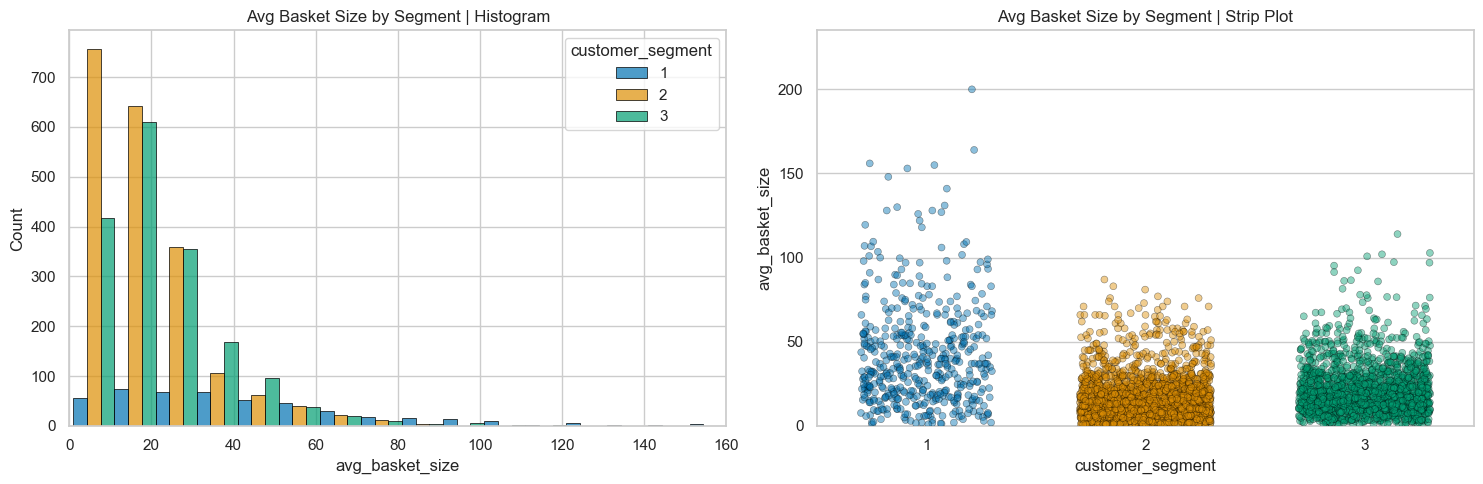

In [87]:
## Average Basket Size

# Creating custom bins
x = cluster_report['avg_basket_size']
w = 10
custom_bins=np.arange(min(x), max(x) + w, w)

# Plot(s)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

histplot_cluster(cluster_report, 'avg_basket_size',
                   bins=custom_bins, xlim=(0, 160),
                   title='Avg Basket Size by Segment | Histogram', ax=ax1)

strip_plot_cluster(cluster_report, 'avg_basket_size',
                   alpha=0.45, jitter=0.3, linewidth=0.4, ylim=(0, 235), 
                   title='Avg Basket Size by Segment | Strip Plot', ax=ax2)

plt.savefig("plots/km_avg_basket_size", dpi=200)

print('Avg Basket Size mean values:')
display((cluster_report.groupby('customer_segment')['avg_basket_size'].mean()).round(2))
print('Avg Basket Size median values:')
(cluster_report.groupby('customer_segment')['avg_basket_size'].median()).round(2)

**Observations:** Yet again, segment 1 has high basket size variance, with a mean average of 42 and median average of 37. These customer typically purchase larger quantities compared to our other segments and tie in with our assumption about them being bulk shoppers. Furthermore, our plots of average basket size confirms our suspicion about segment 2 and 3. In terms of relative proportions to other segments, segment 2 typically purchases lower quantities (17 basket avg) at a higher frequency, while segment 3 typically purchases bigger quantities (21 basket avg) at lower frequencies. 

[Back to Contents](#back)

<br>

LTV mean values:


customer_segment
1    1123.35
2     289.32
3     211.76
Name: ltv, dtype: float64

LTV median values:


customer_segment
1    981.18
2    259.06
3    170.07
Name: ltv, dtype: float64

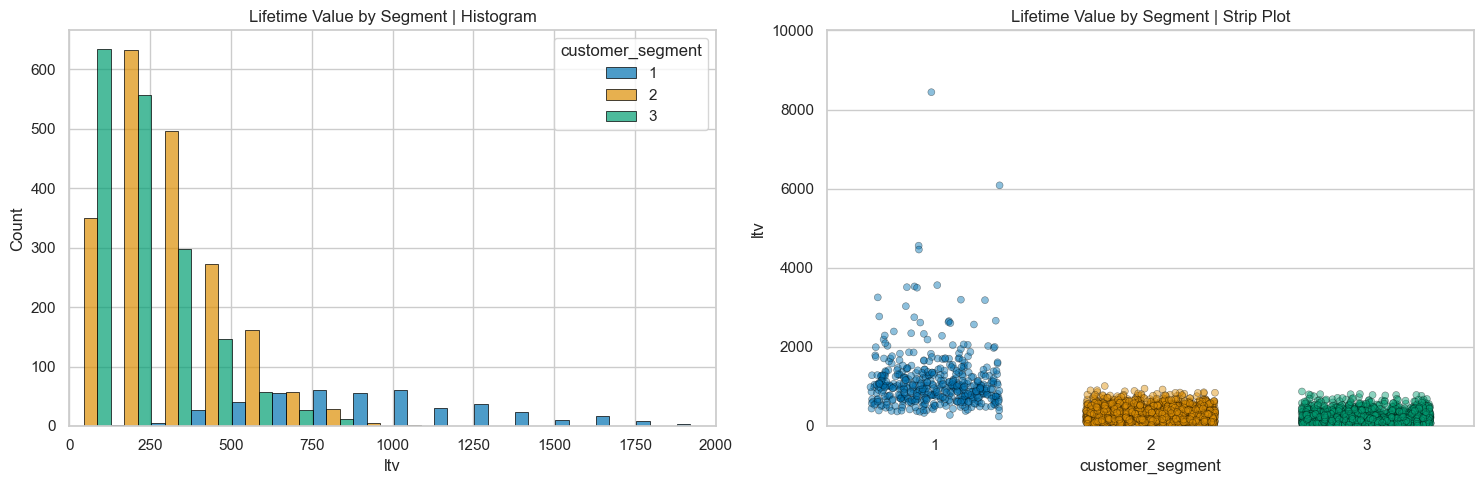

In [88]:
# Lifetime Value (LTV)

# Creating custom bins
x = cluster_report['ltv']
w = 125
custom_bins=np.arange(min(x), max(x) + w, w)


# Plot(s)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

histplot_cluster(cluster_report, 'ltv',
                   bins=custom_bins, xlim=(0, 2000),
                   title='Lifetime Value by Segment | Histogram', ax=ax1)

strip_plot_cluster(cluster_report, 'ltv',
                   alpha=0.45, jitter=0.3, linewidth=0.4, ylim=(0, 10000), 
                   title='Lifetime Value by Segment | Strip Plot', ax=ax2)

plt.savefig("plots/km_LTV", dpi=200)

print('LTV mean values:')
display((cluster_report.groupby('customer_segment')['ltv'].mean()).round(2))
print('LTV median values:')
(cluster_report.groupby('customer_segment')['ltv'].median()).round(2)

**Observations:** Segment 1's average LTV (\\$1123) is no doubt the highest amongst our bunch of segments, with much larger basket size averages and relatively higher purchase frequencies. Segment 2's LTV (\\$289) is middling of the road, and tops segment 3 purely due to its relatively lower price sensitivity, lower transaction delta and higher purchase frequency. A caveat to note however, is that the lifetime age for this segment is extremely low, at about 1.5 months.
Segments 3's LTV (\\$211) is lowest amongst all segments, and this can be attributed to its very sparse purchase frequency and large transaction time deltas, though it is important to note they comprise of loyal customers who have been with the business for extended period of time, or an average of 8 months.

[Back to Contents](#back)

<br>

# 6. Findings and Overall Conclusion <a id='findings' ><a/>


## 6.1. Hypothesis Exploration towards Customer Segmentation <a id='findings1' ><a/>
    
1. <u>Seasonalities affects sales, whereby sales are highest towards the end of the year</u> &ndash; *Accepted*.
- We saw spikes in total revenue and total order volume in the months of **September to November**. These are the months where most of customers are preparing for the festive holidays and end of year vacations and thus, showcase a high willingness to spend. December saw consistently low performance, and this could be due to the nature of the household-good business, whereby goods of this nature aren't of the 'gift' giving type, and hence see lower overall transactions for it. **January** has promise as it recorded relatively high average basket size and purchase value metrics, and shows that there are subset of people cashing in on the post-Christmas promotions. Months from February to June overall, have nothing to write home about, and could be a good time period to run promotions and encourage spending.

2. <u>Customers are more likely to make purchases over the weekend than weekdays</u> &ndash; *Refuted*. 
- Weekdays were found to be better performing. Particularly **Friday's** have the highest traffic, while Saturday had the lowest performance amongst all observed days of the week. Sunday unfortunately had no observations on record whatsoever, possibly indicating the business's off day.

3. <u>Customers with shorter time deltas between transactions are more likely to exhibit higher repeat purchase behavior, indicating higher engagement/loyalty. (and vice versa)</u> &ndash; *Accepted to a degree*.
- The relationship observed through a scatterplot is one of a non-linear nature and we observe low-moderate positive correlation for purchase frequency the lower a customer's time delta gets based upon the Spearman's coefficient. However, this trend starts to increase shift upwards starting from the **90-day to 2-day time delta**, and hence is our threshold for high-engagement indication. The correlation isn't anything spectacular, but is noticeably nuanced at the very least from the beginning of our time-delta threshold that we had set.

4. <u>Purchase frequency (first order month) and average purchase frequency (proceeding months) are likely dependent on each other</u> &ndash; *Rejected*.  
- Our chi test attained an extremely high p-value above our statistical significance thresholdd, thus we have no reason to believe there is dependence between Purchase Frequency (first) order month and average purchase frequency (proceeding months). The only thing we may conclusively bet on, is that **customers who purchased once in the first month, will likely commit to similar behaviour in proceeding months.**

5. <u>(1) Purchase Frequency has a higher impact on LTV compared to Average Purchase Value and Average Basket Size and (2) Customer segments differ in terms of their average basket size (average quantity) and average frequency of purchase</u> &ndash; *Both Rejected*. 
- **Purchase Value had the highest positive correlation with LTV**, followed by Purchase frequency with moderate positive correlation. Basket Size had low positive correlation with LTV and little to no correlation whatsoever with Purchase Frequency, as observed with a near 0 Spearman's Correlation Coefficient. The Purchase Value metric is dominant then, but Purchase Frequency still has great importance. Basket Size has low-moderate correlation with LTV while having no predictive value of Purchase Value in a vacuum.

[Back to Contents](#back)

<br>

## 6.2. RFM Segmentation <a id='findings2' ><a/>

We grouped all customers into classes of individual and consolidated Recency, Frequency and Monetary feature scores. The RFM table helps the client answer various questions about a customer's behaviour, and moving forward allows for very granular targeting for personalized marketing at the customer level. Here are some of the questions (but not limited to) we answered in RFM analysis:

1. Who are the client's best customers? (Highest RFM score == 444)
2. Who are the client's valuable customers who are almost lost? (RFM score == 244)
3. Who are cheap lost customer? (RFM score == 111)
4. Who are the client's valuable customers who are already lost? (RFM score == 144)
5. Who are high potential customers? (R-score >= 3, F-score == 3, M-score >= 3)
6. Who are new customers? (R-score == 4, F-score == 1, M-score <= 2)
7. Who are occasional buyers? (R-score <= 2, F-score <= 2)
8. Who are loyal customers? (F-Score == 4)
9. Who are big spenders? (M-Score == 4)
                                                         
> **NOTE:** The RFM model may be used by the client for a more granular segmentation process at their own discretion; a link to a dashboard will be provided. Otherwise, the K-Means model summarized below may be used for a higher-level perspective.
>    
>*Dashboard Link: https://public.tableau.com/app/profile/jonathan.chan5881/viz/Finals-RFMSegmenationDashboard/Dashboard1?publish=yes*

[Back to Contents](#back)

<br>

## 6.3. K-Means Clustering Segmentation <a id='findings3' ><a/>

**N/B:** *Our best silhouette score was 0.293. This is not the best, and hence we can expect some non-optimal clustering of customers. Nevertheless, we achieved 3 distinct segments based on the most optimal silhouette and inertia scores. Here are our findings*:
    
1. **Segment 1**
    - Average of 3.43 lifetime months
    - Average transaction time-delta of 21 days - Comprises a large cluster of one-and-done shoppers. Remaining customers are repeat purchasers who are either frequent purchasers within a month time-delta, or periodic shoppers with time deltas as far as a 6 months time-delta. 
    - Most price sensitive (82% share)
    - 2nd largest segment share of seasonal shoppers (68% share)
    - Average monthly purchase typically once-a-month, with variance towards the twice-a-month range and beyond (1.69 avg)
    - Average basket size of about 42, which is highest amongst all segments
    - Highest purchase value with a mean of \\$821
    - Highest LTV, at a mean of \\$1123
        > This segment comprises customers who are largely bulk buyers. This was inferred via its largest average basket size, with a substantial margin to the segment with the next largest basket size at 21. This could be for a multitude of reasons, like institutional purchases, reselling or corporate gifting. While segment 1 has a lower relative sample size compared to our others, their LTV values stand out to us and comprise a significant amount of revenue for the company. This is compounded by the fact this segment typically makes repeat purchases within a month or less, which indicates some loyalty in a vacuum. 
        >
        >**Recommendations:** Its low lifetime age of 3.43 months means we have not really seen the full extent of this group's behaviour, and we cannot determine if there is innate loyalty to the brand until a later date. Couple this with the fact that this segment has the highest average basket size indicates it can be profitable if we can encourage them to continue their purchase behaviour in the future. There is an opportunity for a loyalty program that rewards customers for repeat bulk purchases. One thing to note, is that these customers are those who enjoy a good bargain, with 82% share of them being price sensitive and a good amount of them being seasonal shoppers. The client may want to implement cross-selling recommendation blocks for similarly affordable goods, which may further increase repeat purchase behavior.
    
2. **Segment 2**
    - Average of 1.5 lifetime months
    - Average transaction time-delta of 10.7 days - Comprises a large cluster of one-and-done shoppers, a moderate cluster of frequent buyers within a 1 month time delta, and periodic shoppers no larger than 100-days time delta. 
    - Lowest price sensitivity (75% segment share)
    - Smallest customer proportion of seasonal shoppers (44% share)
    - Average monthly purchase typically once-a-month, with some variance towards twice-a-month. (1.2 avg)
    - Lowest observed average basket size with a mean of 17
    - Lowest observed average purchase value, with a mean of \\$247
    - 2nd-highest LTV, at a mean of \\$289
        > This segment has great potential but needs to be monitored. Its lowest lifetime age indicates we have yet to see the full extent of the segment's behaviour and relatedly, their loyalty. While this segment exhibited the lowest metrics for average basket size and average purchase value, there are some key highlights, which would be its higher propensity to purchase more frequently, its lowest proportion share of seasonal shoppers and relatedly, its lowest price sensitivity. This accordingly has resulted in the 2nd highest LTV amongst our segments, possibly due to its higher transaction frequency and a somewhat disinclined attitude towards price consciousness. 
        >
        >**Recommendations:** The segment's higher purchase frequency behaviour, coupled with lower transaction-delta and disinclination towards bargains and cheaper goods (to an extent) can be leveraged to increase overall customer value and loyalty. While it needs more monitoring, potential is there to upsell slightly more premium product ranges. In terms of improving this segment's low basket size and purchase value, the client may want to explore cross-category promotions that incentivizes these customers into exploring different product lines.
            
3. **Segment 3**
    - Average of 8.1 lifetime months
    - Average transaction time-delta of 94 days - No one-and-done shoppers are observed. Comprises loyal but periodic shoppers, as average transaction delta is the highest observed amongst segments. Majority of observations are seen scattered below the 100-day time delta, while a significant portion of other observations are seen above that.   
    - Most price sensitive (82% share)
    - Largest amount of seasonal shopper proportion (83% share)
    - Lowest average monthly purchase frequency at roughly 0.64/month average.
    - 2nd-highest average basket size, with a mean average of 21 
    - 2nd-highest observed average purchase value, with a mean average of \\$331
    - Lowest LTV, at a mean of \\$211
        > This segment of customers are our most loyal/oldest customers as they average approximately 8 months of lifetime age values. The biggest drawbacks are the fact that they do not purchase as frequently as other segments, with the largest observed transaction delta and lowest average purchase frequency on record. They also represent the segment with the highest share of seasonal shoppers and are solely focused on price consciousness. As they are our most loyal customer base, the biggest benefit from this is the potential for word of mouth traffic and brand advocacy. 
        >
        >**Recommendations:** This segment should be given the most attention, as it comprises our longest and most loyal customers. Its long lifetime age also indicates we are more or less sure of its behavioural charateristics and can act without any assumptions and biases. The main notion is that with brand loyalty, comes increased brand salience. The client may want to create referral programs and(or) incentives for customer advocacy that will increase purchase frequency as well as generate new-user acquisition. 

[Back to Contents](#back)